<a href="https://colab.research.google.com/github/khanhlinh1808/UNET-/blob/main/UNET_implementation_in_polyps_detection_%26_evaluate_by_IoU_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install utils
import utils

In [ ]:
import os
import imageio

import numpy as np
import torch
import torchvision.transforms as transforms


# Save images to folder and create a custom dataloader that loads them from their path. More involved than method 1 but allows for greater flexibility
# Requires 3 functions: __init__ to initialize the object, and __len__ and __get__item for pytorch purposes. More functions can be added as needed, but those 3 are necessary for it to function with pytorch
class myDataSet(object):

    def __init__(self, ids, path_images, path_masks, transforms):
        "Initialization"
        self.ids = ids
        self.path_images = path_images
        self.path_masks = path_masks
        self.transforms = transforms

    def __len__(self):
        "Returns length of dataset"
        return len(self.ids)  

    def __getitem__(self, index):
        "Return next item of dataset"
        # Define path to current image and corresponding mask
        path_img = os.path.join(self.path_images, self.ids[index])
        path_mask = os.path.join(self.path_masks, self.ids[index])

        # Load image and mask:
        #     .jpeg has 3 channels, channels recorded last
        #     .jpeg records values as intensities from 0 to 255
        #     masks for some reason have values different to 0 or 255: 0, 1, 2, 3, 4, 5, 6, 7, 248, 249, 250, 251, 252, 253, 254, 255
        img = imageio.imread(path_img) / 255
        mask = imageio.imread(path_mask)[:, :, 0] / 255
        mask = mask.round() # binarize to 0 or 1 
        
        # note, resizing happens inside transforms
        
        # convert to Tensors and fix the dimentions
        img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])) # Pytorch uses the channels in the first dimension
        mask = torch.FloatTensor(mask).unsqueeze(0) # Adding channel dimension to label
        
        # apply transforms/augmentation to both image and mask together
        sample = torch.cat((img, mask), 0) # insures that the same transform is applied
        sample = self.transforms(sample)
        img = sample[:img.shape[0], ...]
        mask = sample[img.shape[0]:, ...]

        return img, mask

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# -----------------------------------------------------------------------------
# to be used for validation during training

def iou_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W -> BATCH x H x W
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean()

# -----------------------------------------------------------------------------
# to be used for validation for trainied models


def iou_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor):
    # intersection = tp
    # union = tp + fp + fn
    # iou = tp / (tp + fp + fn) = intersection / union

    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean()


def dice_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor):
    # intersection = tp
    # union = tp + fp + fn
    # dice = 2 * tp / (2 * tp + fp + fn) = 2*intersection / (intersection + union)

    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    dice = (2*intersection + SMOOTH) / (intersection + union + SMOOTH)  # We smooth our devision to avoid 0/0

    return dice.mean()


def precision_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor):
    # intersection = tp
    # tpfp = tp + fp
    # precision = tp / (tp + fp) = intersection / tpfp

    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    tpfp = (labels).float().sum((1, 2))                    # Will be zero if both are 0
    precision = (intersection + SMOOTH) / (tpfp + SMOOTH)  # We smooth our devision to avoid 0/0

    return precision.mean()


def recall_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor):
    # intersection = tp
    # tpfn = tp + fn
    # recall = tp / (tp + fn) = intersection / tpfn


    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    tpfn = (outputs).float().sum((1, 2))                   # Will be zero if both are 0
    recall = (intersection + SMOOTH) / (tpfn + SMOOTH)     # We smooth our devision to avoid 0/0

    return recall.mean()


def fbeta_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor, beta:float):
    # intersection = tp
    #
    # tpfp = tp + fp
    # precision = tp / (tp + fp) = intersection / tpfp
    #
    # tpfn = tp + fn
    # recall = tp / (tp + fn) = intersection / tpfn
    #
    # fbeta = (1 + beta^2) * (precision * recall) / ((beta^2 * precision) + recall)
    # https://www.quora.com/What-is-the-F2-score-in-machine-learning

    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0

    tpfn = (outputs).float().sum((1, 2))                   # Will be zero if both are 0
    recall = (intersection + SMOOTH) / (tpfn + SMOOTH)     # We smooth our devision to avoid 0/0

    tpfp = (labels).float().sum((1, 2))                    # Will be zero if both are 0
    precision = (intersection + SMOOTH) / (tpfp + SMOOTH)  # We smooth our devision to avoid 0/0

    f_beta = (1 + beta ** 2) * (precision * recall) / ((beta **2 * precision) + recall)

    return f_beta.mean()


def accuracy_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor):

    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    acc = (outputs == labels).float().mean((1, 2))

    return acc.mean()



# -----------------------------------------------------------------------------
# Credit to: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return -IoU


class IoUBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoUBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = - (intersection + smooth)/(union + smooth)

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        IoU_BCE = BCE + IoU

        return IoU_BCE

**UNET Architecture**

In [ ]:
  import torch
  import torchsummary

# Basic UNet architecture. The output channel for segmentation should be equal to number of classes we want to segment the image into. For a binary segmentation, this is a value of 1.
  class UNet(torch.nn.Module):

    def conv_block(self, channel_in, channel_out):
        return torch.nn.Sequential(
            torch.nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True)
        )


    def __init__(self, channel_in, channel_out, bilinear=None):
        super(UNet, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        # initial convolutional block
        self.initial = self.conv_block(channel_in, 64)
        
        # encoder layers
        self.down0 = self.conv_block(64, 128)
        self.down1 = self.conv_block(128, 256)
        self.down2 = self.conv_block(256, 512)
        self.down3 = self.conv_block(512, 1024)
        
        # decoder layers
        self.up0_0 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up0_1 = self.conv_block(1024, 512)
        self.up1_0 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up1_1 = self.conv_block(512, 256)
        self.up2_0 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2_1 = self.conv_block(256, 128)
        self.up3_0 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3_1 = self.conv_block(128, 64)
        
        # final layer before output
        self.final = torch.nn.Conv2d(64, channel_out, kernel_size=1)

    def forward(self,x):
        "Forward pass"
        x_in= self.initial(x)
        enc0 = self.down0(torch.nn.MaxPool2d(2)(x_in))
        enc1 = self.down1(torch.nn.MaxPool2d(2)(enc0))
        enc2 = self.down2(torch.nn.MaxPool2d(2)(enc1))
        enc3 = self.down3(torch.nn.MaxPool2d(2)(enc2))
        
        dec0 = self.up0_0(enc3)
        diff0 = torch.FloatTensor(list(enc2.size())[2:]) - torch.FloatTensor(list(dec0.shape))[2:]
        dec0 = torch.nn.functional.pad(dec0, (int((diff0/2).floor()[0]), int((diff0/2).ceil()[0]), int((diff0/2).floor()[1]), int((diff0/2).ceil()[1])))
        dec0 = self.up0_1(torch.cat((enc2, dec0), dim=1))

        dec1 = self.up1_0(dec0)
        diff1 = torch.FloatTensor(list(enc1.size())[2:]) - torch.FloatTensor(list(dec1.shape))[2:]
        dec1 = torch.nn.functional.pad(dec1, (int((diff1/2).floor()[0]), int((diff1/2).ceil()[0]), int((diff1/2).floor()[1]), int((diff1/2).ceil()[1])))
        dec1 = self.up1_1(torch.cat((enc1, dec1), dim=1))

        dec2 = self.up2_0(dec1)
        diff2 = torch.FloatTensor(list(enc0.size())[2:]) - torch.FloatTensor(list(dec2.shape))[2:]
        dec2 = torch.nn.functional.pad(dec2, (int((diff2/2).floor()[0]), int((diff2/2).ceil()[0]), int((diff2/2).floor()[1]), int((diff2/2).ceil()[1])))
        dec2 = self.up2_1(torch.cat((enc0, dec2), dim=1))

        dec3 = self.up3_0(dec2)
        diff3 = torch.FloatTensor(list(x.size())[2:]) - torch.FloatTensor(list(dec3.shape))[2:]
        dec3 = torch.nn.functional.pad(dec3, (int((diff3/2).floor()[0]), int((diff3/2).ceil()[0]), int((diff3/2).floor()[1]), int((diff3/2).ceil()[1])))
        dec3 = self.up3_1(torch.cat((x_in, dec3), dim=1))
        
        x_out = self.final(dec3) # ? no activation here
        return x_out

    
if __name__ == "__main__":   
    model = UNet(channel_in=3, channel_out=1)
    torchsummary.summary(model, (3, 128, 128), device='cpu')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]         147,584
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

In [ ]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


**Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc**

In [ ]:
_size = 128, 128
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


**Make your train and validation data loader with option to augment or not**

In [ ]:
path_images = "/content/drive/MyDrive/UNET/train/images"
path_masks = "/content/drive/MyDrive/UNET/train/masks"

with open('/content/drive/MyDrive/UNET/train-val-split/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('/content/drive/MyDrive/UNET/train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]

custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=test_transforms)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [ ]:
BATCH_SIZE = 20

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
!nvidia-smi

Thu Jul 15 06:07:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

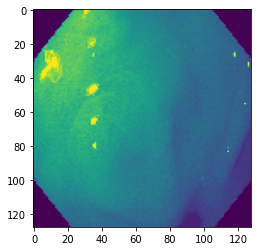

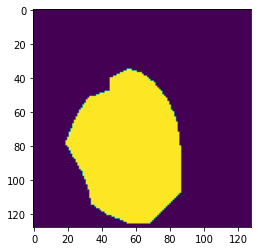

In [ ]:
# Show example images.
image_number = 1
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [ ]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 128, 128])

In [ ]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 128, 128]), array([0., 1.], dtype=float32))

In [ ]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [ ]:
epochs = 100
patience = 10

In [ ]:
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = IoUBCELoss()
model_name = 'UNet_IoUBCELoss_baseline'

 Epoch: 0 of 100, Iter.: 44 of 44, Loss: 0.266813, Val. Loss: 0.249462
 Epoch: 0 of 100, Iter.: 44 of 44, IoU: 0.344421, Val. IoU: 0.225634


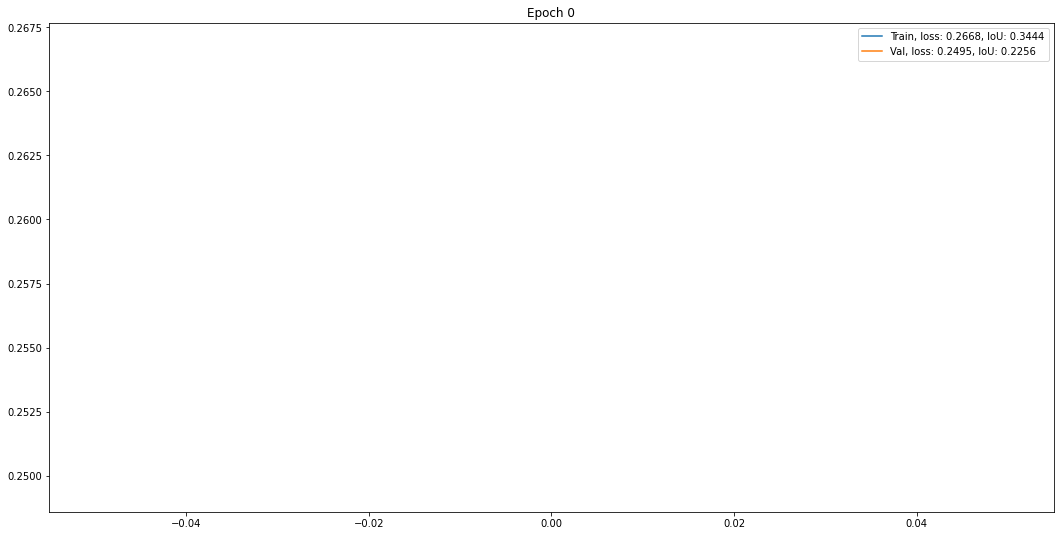

 Epoch: 1 of 100, Iter.: 44 of 44, Loss: 0.105454, Val. Loss: 0.327004
 Epoch: 1 of 100, Iter.: 44 of 44, IoU: 0.427734, Val. IoU: 0.338830


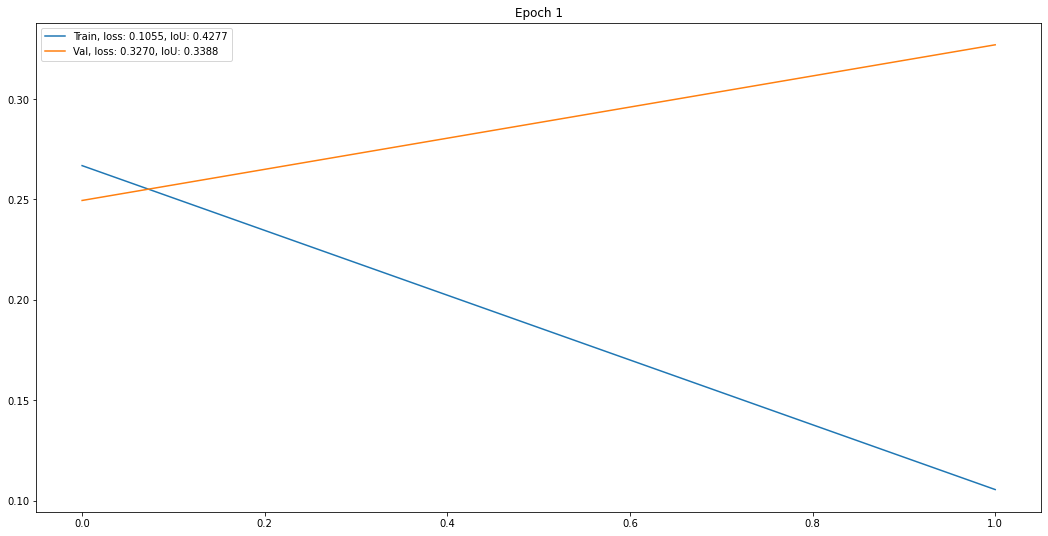

 Epoch: 2 of 100, Iter.: 44 of 44, Loss: 0.035106, Val. Loss: 0.162899
 Epoch: 2 of 100, Iter.: 44 of 44, IoU: 0.459830, Val. IoU: 0.376850


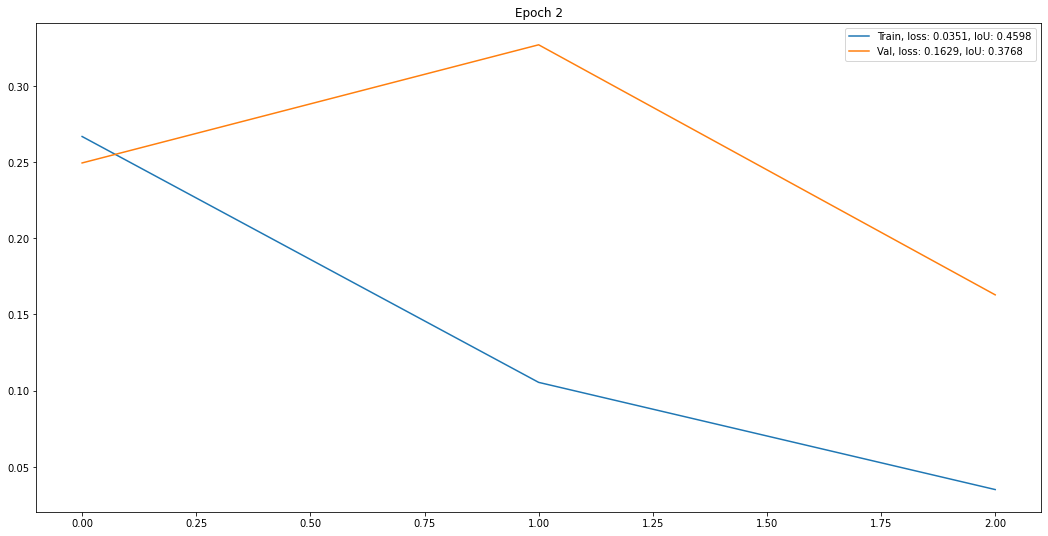

 Epoch: 3 of 100, Iter.: 44 of 44, Loss: -0.028041, Val. Loss: 0.195134
 Epoch: 3 of 100, Iter.: 44 of 44, IoU: 0.493039, Val. IoU: 0.368374


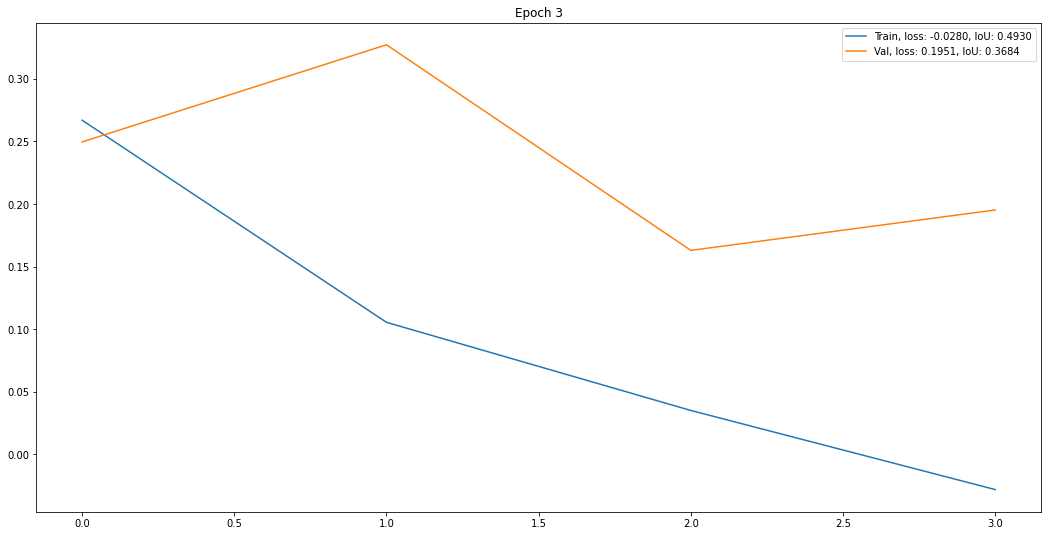

 Epoch: 4 of 100, Iter.: 44 of 44, Loss: -0.082779, Val. Loss: 0.061906
 Epoch: 4 of 100, Iter.: 44 of 44, IoU: 0.528886, Val. IoU: 0.415904


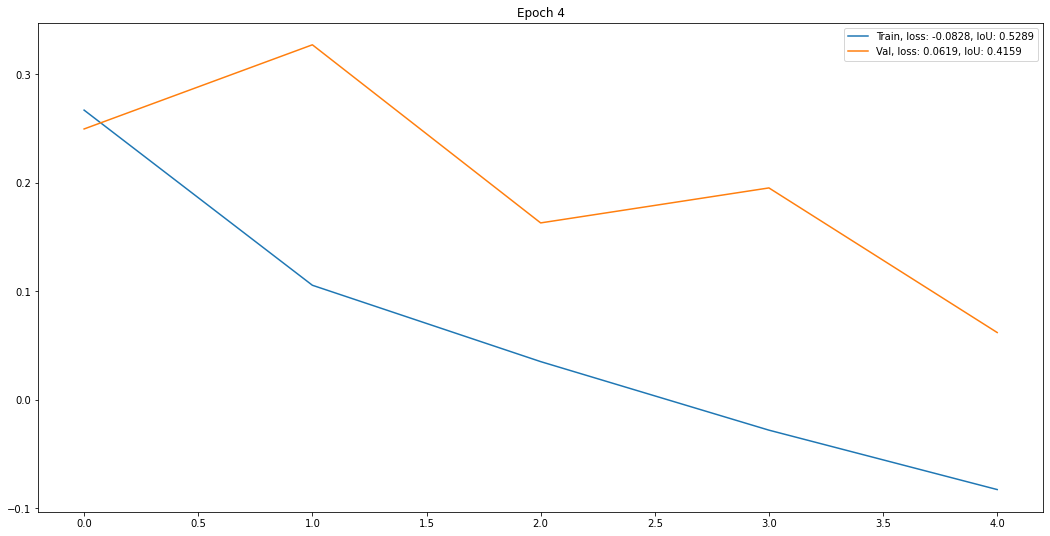

 Epoch: 5 of 100, Iter.: 44 of 44, Loss: -0.147158, Val. Loss: 0.164783
 Epoch: 5 of 100, Iter.: 44 of 44, IoU: 0.569331, Val. IoU: 0.367128


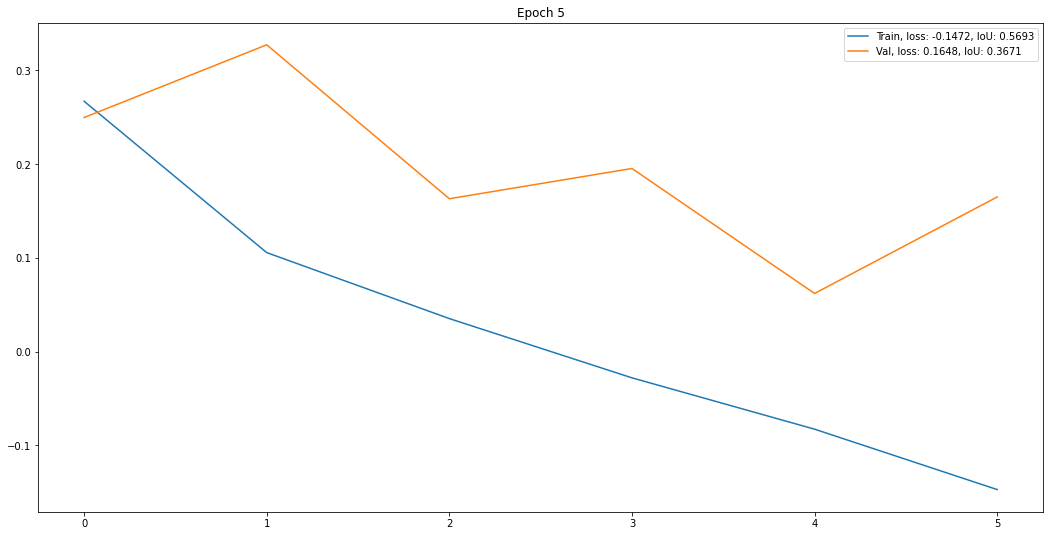

 Epoch: 6 of 100, Iter.: 44 of 44, Loss: -0.206397, Val. Loss: 0.165775
 Epoch: 6 of 100, Iter.: 44 of 44, IoU: 0.603480, Val. IoU: 0.181968


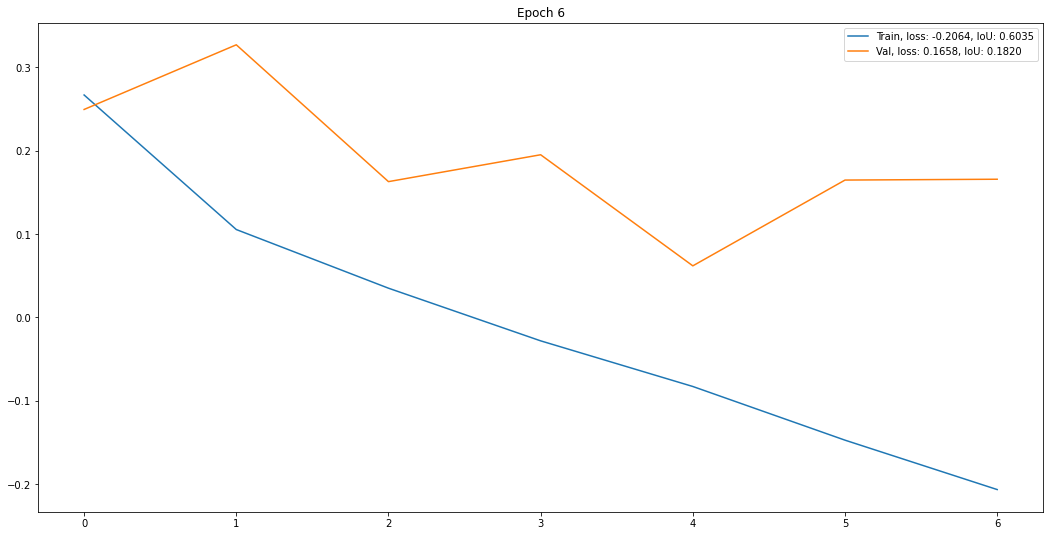

 Epoch: 7 of 100, Iter.: 44 of 44, Loss: -0.232316, Val. Loss: -0.037889
 Epoch: 7 of 100, Iter.: 44 of 44, IoU: 0.612794, Val. IoU: 0.468621


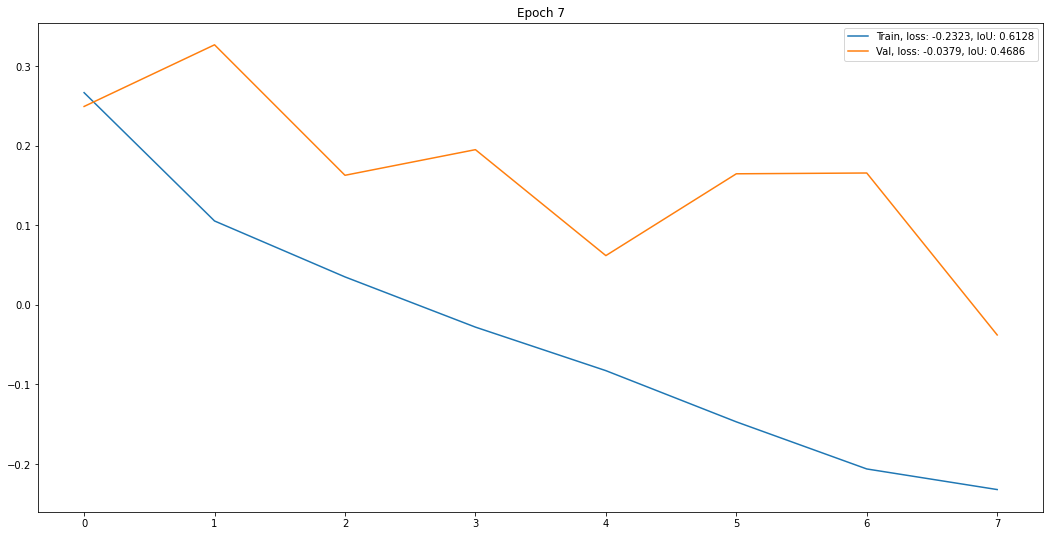

 Epoch: 8 of 100, Iter.: 44 of 44, Loss: -0.284240, Val. Loss: -0.026040
 Epoch: 8 of 100, Iter.: 44 of 44, IoU: 0.638000, Val. IoU: 0.473664


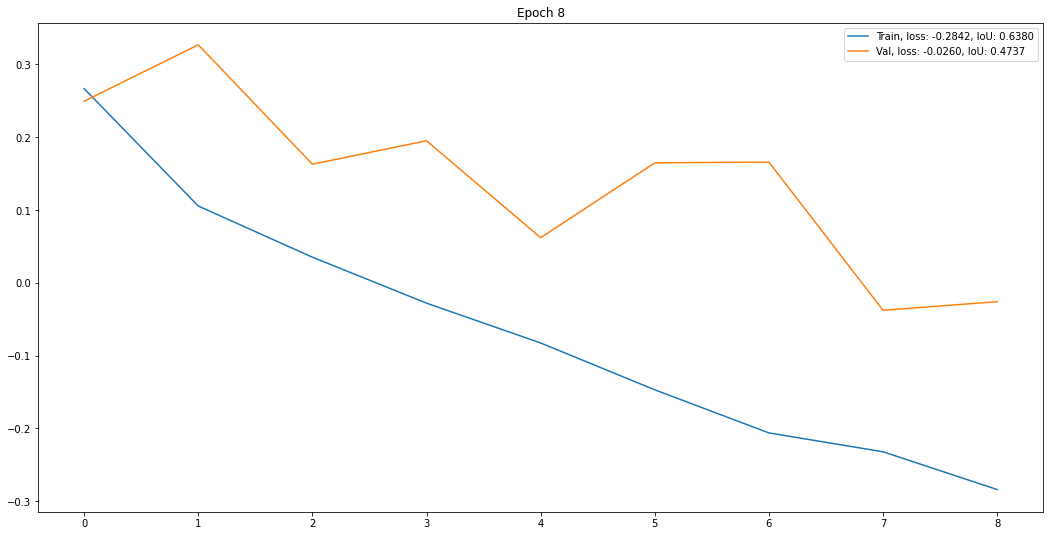

 Epoch: 9 of 100, Iter.: 44 of 44, Loss: -0.335517, Val. Loss: -0.085453
 Epoch: 9 of 100, Iter.: 44 of 44, IoU: 0.670183, Val. IoU: 0.484975


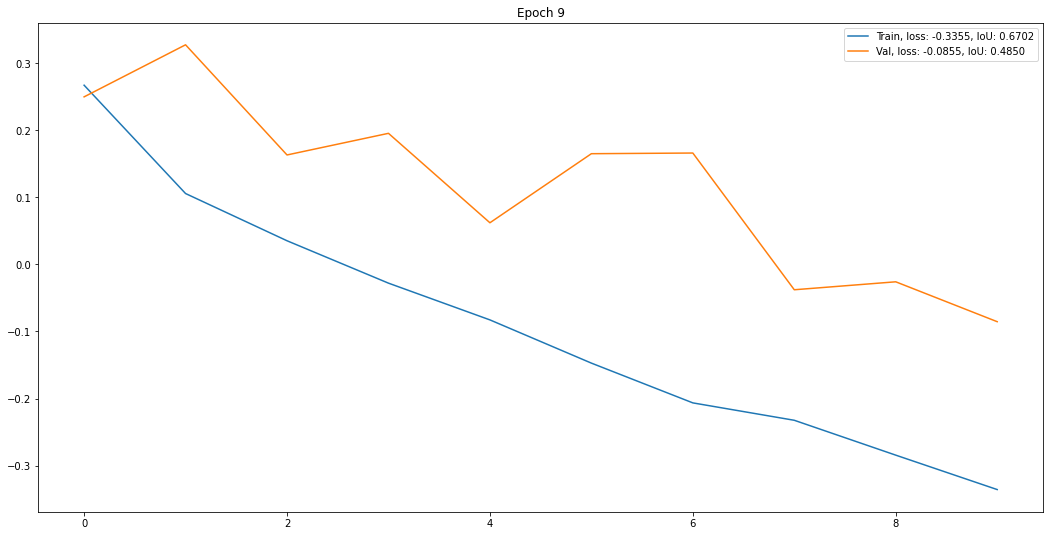

 Epoch: 10 of 100, Iter.: 44 of 44, Loss: -0.373245, Val. Loss: -0.082782
 Epoch: 10 of 100, Iter.: 44 of 44, IoU: 0.690288, Val. IoU: 0.490283


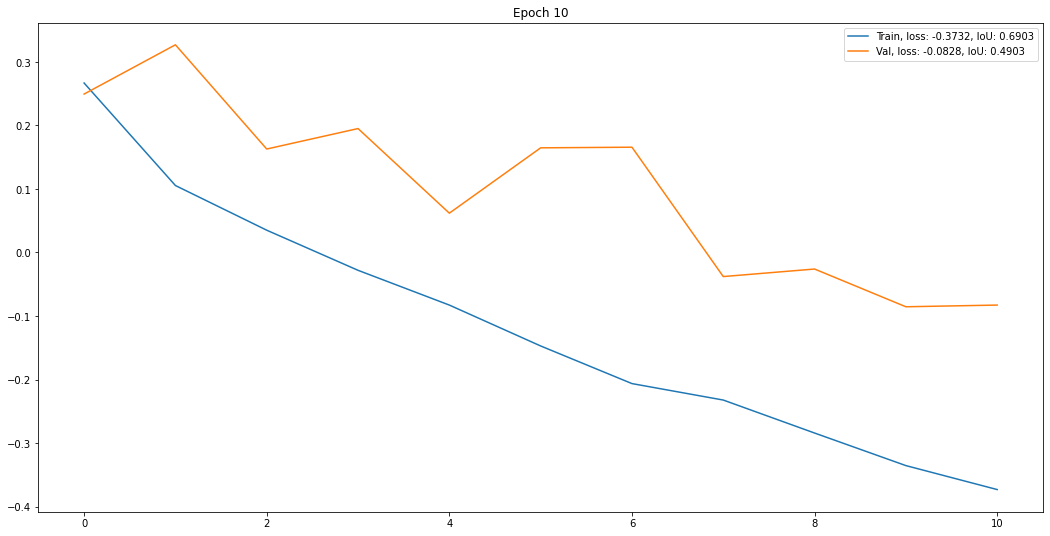

 Epoch: 11 of 100, Iter.: 44 of 44, Loss: -0.395671, Val. Loss: -0.162411
 Epoch: 11 of 100, Iter.: 44 of 44, IoU: 0.701791, Val. IoU: 0.524609


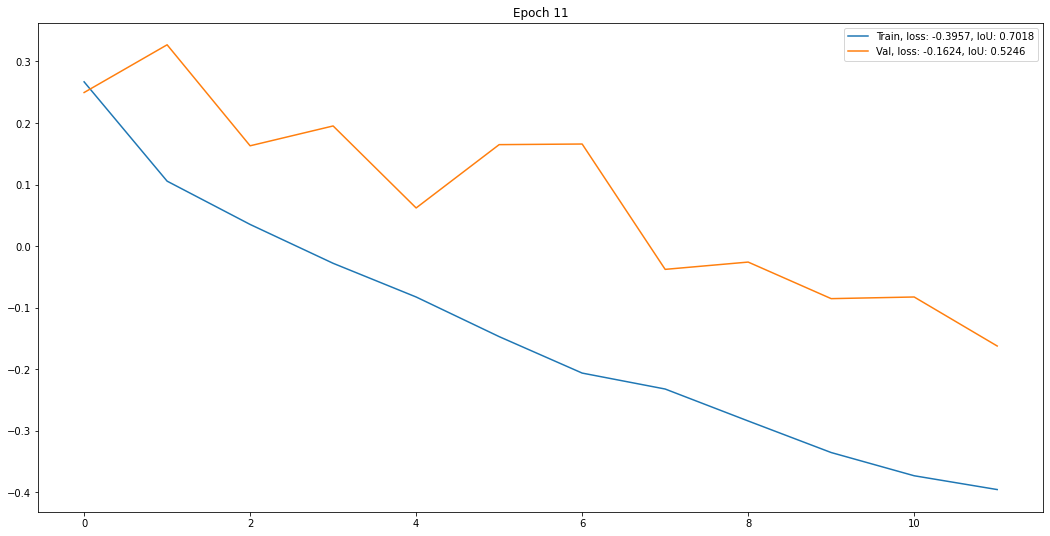

 Epoch: 12 of 100, Iter.: 44 of 44, Loss: -0.452446, Val. Loss: -0.151174
 Epoch: 12 of 100, Iter.: 44 of 44, IoU: 0.730491, Val. IoU: 0.549538


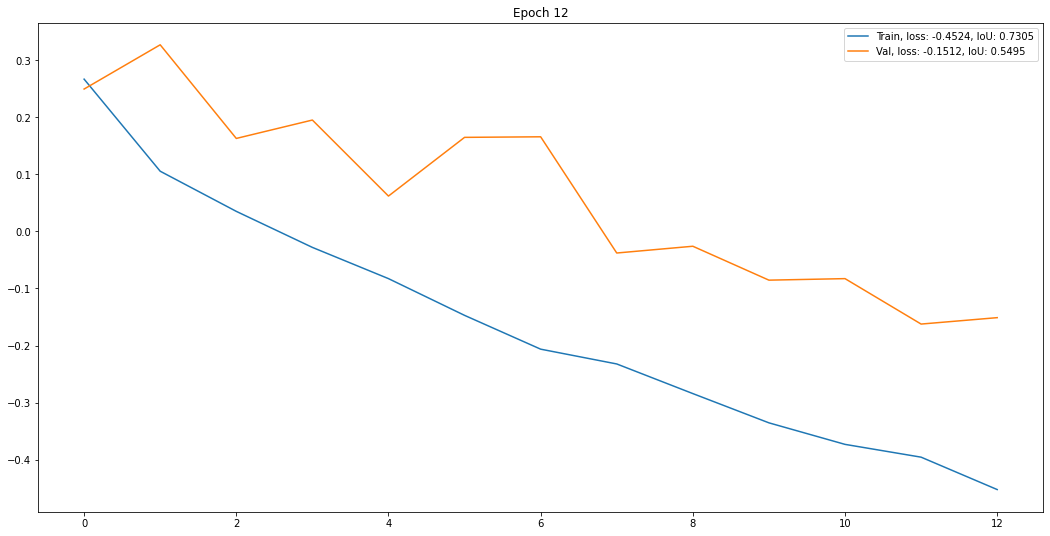

 Epoch: 13 of 100, Iter.: 44 of 44, Loss: -0.492055, Val. Loss: -0.166982
 Epoch: 13 of 100, Iter.: 44 of 44, IoU: 0.750091, Val. IoU: 0.557689


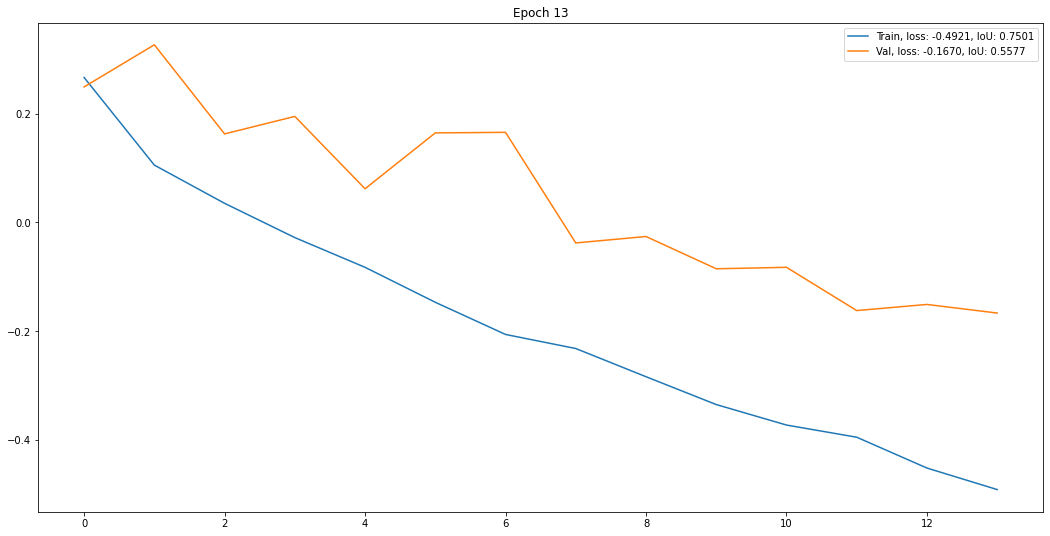

 Epoch: 14 of 100, Iter.: 44 of 44, Loss: -0.527095, Val. Loss: -0.122656
 Epoch: 14 of 100, Iter.: 44 of 44, IoU: 0.771870, Val. IoU: 0.558538


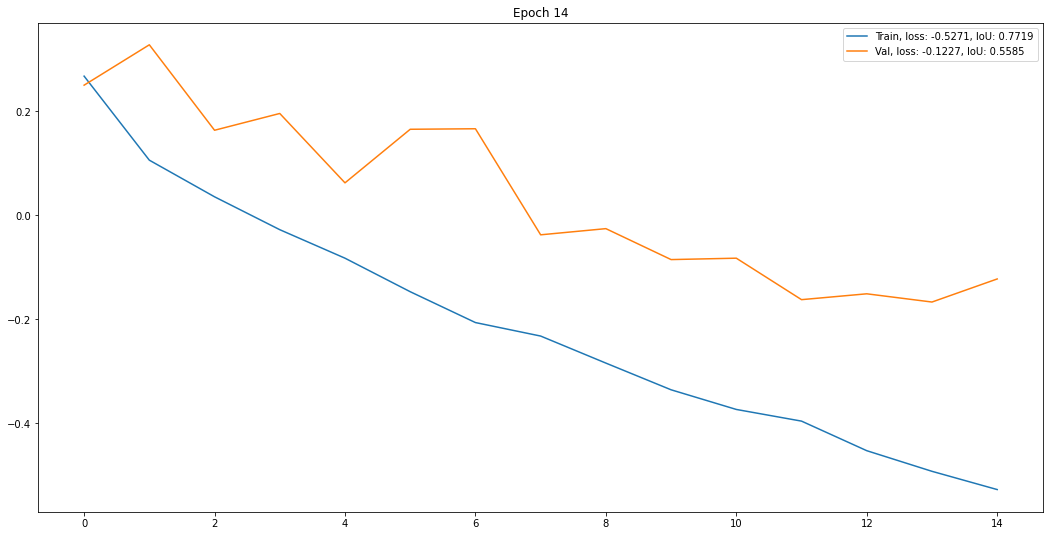

 Epoch: 15 of 100, Iter.: 44 of 44, Loss: -0.546210, Val. Loss: -0.128704
 Epoch: 15 of 100, Iter.: 44 of 44, IoU: 0.780005, Val. IoU: 0.542547


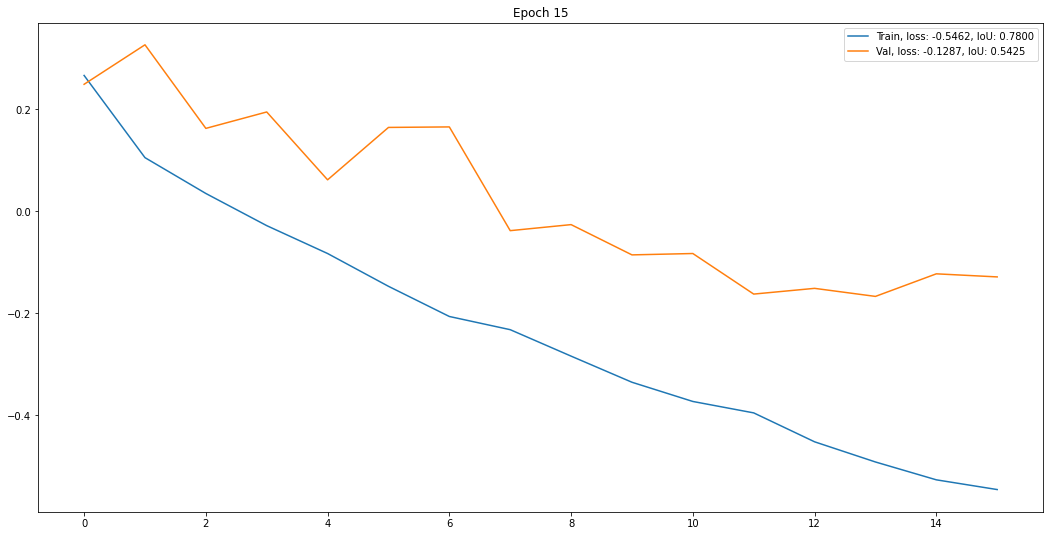

 Epoch: 16 of 100, Iter.: 44 of 44, Loss: -0.582062, Val. Loss: -0.073198
 Epoch: 16 of 100, Iter.: 44 of 44, IoU: 0.794888, Val. IoU: 0.512896


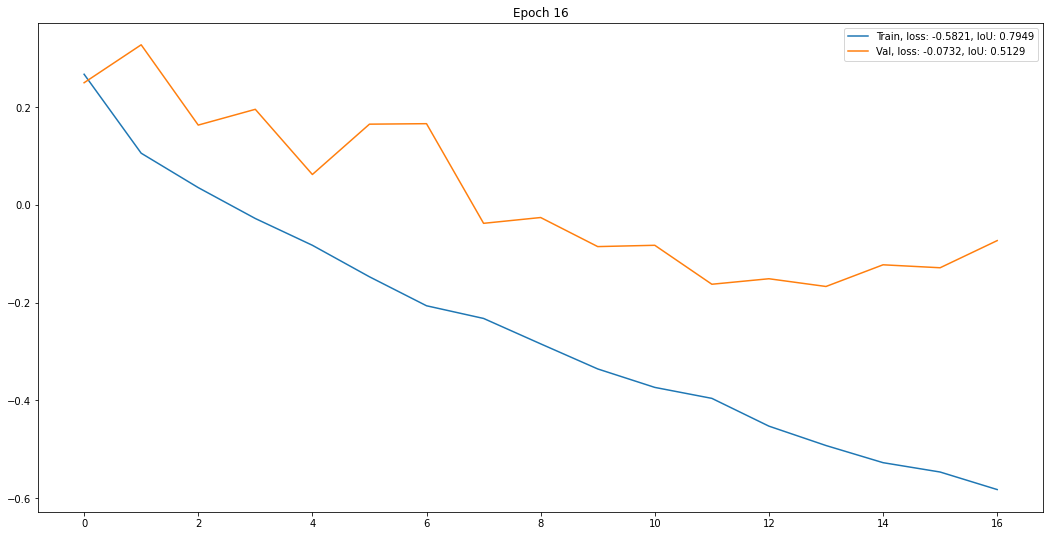

 Epoch: 17 of 100, Iter.: 44 of 44, Loss: -0.611113, Val. Loss: -0.142258
 Epoch: 17 of 100, Iter.: 44 of 44, IoU: 0.803893, Val. IoU: 0.573962


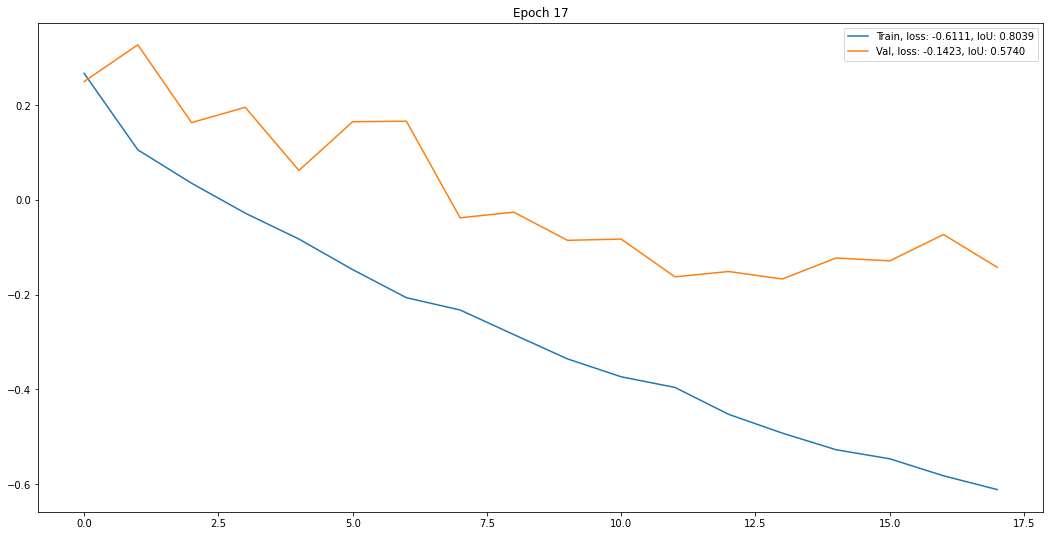

 Epoch: 18 of 100, Iter.: 44 of 44, Loss: -0.617960, Val. Loss: -0.204154
 Epoch: 18 of 100, Iter.: 44 of 44, IoU: 0.796234, Val. IoU: 0.590228


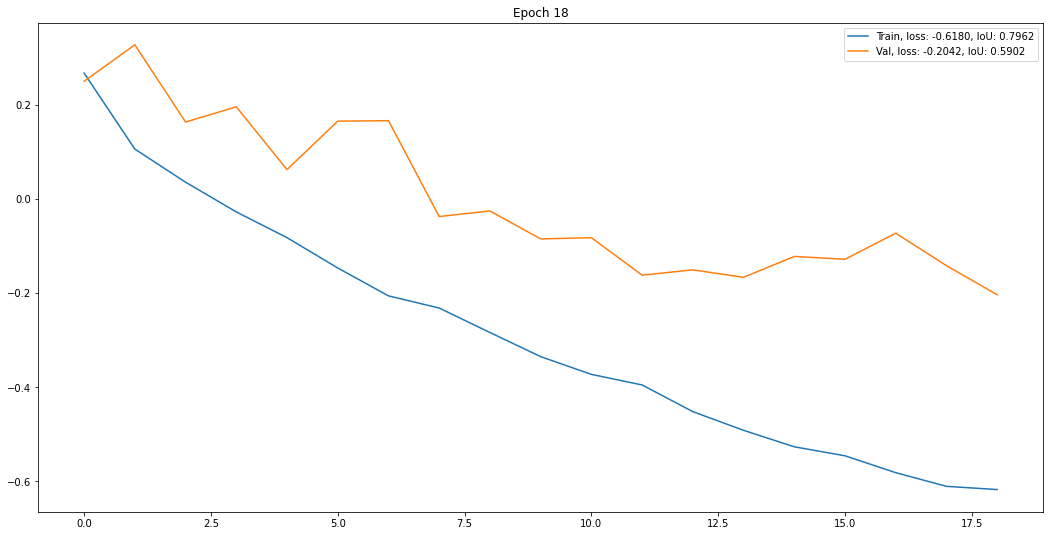

 Epoch: 19 of 100, Iter.: 44 of 44, Loss: -0.655410, Val. Loss: -0.188494
 Epoch: 19 of 100, Iter.: 44 of 44, IoU: 0.827213, Val. IoU: 0.584740


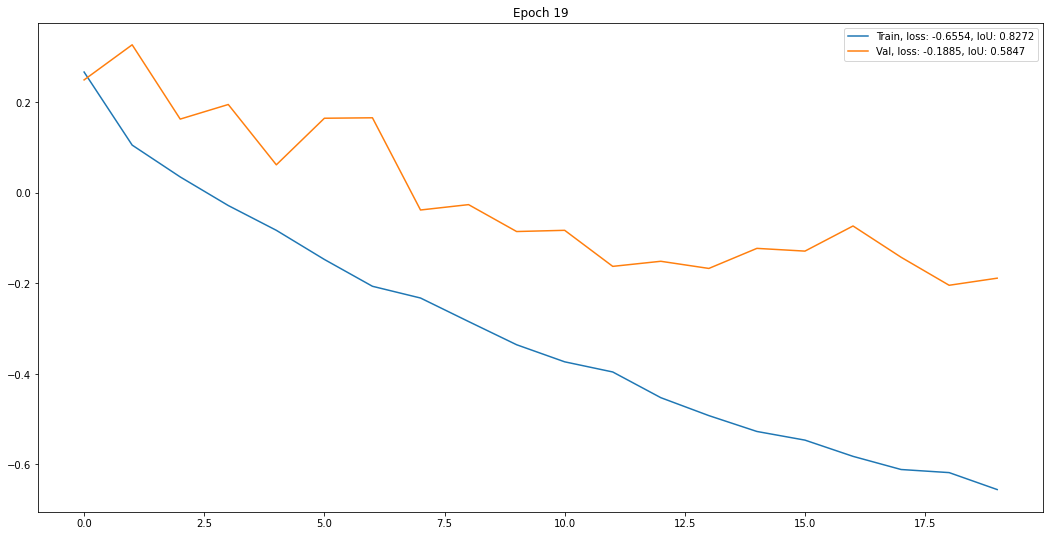

 Epoch: 20 of 100, Iter.: 44 of 44, Loss: -0.653971, Val. Loss: 0.061933
 Epoch: 20 of 100, Iter.: 44 of 44, IoU: 0.817686, Val. IoU: 0.480856


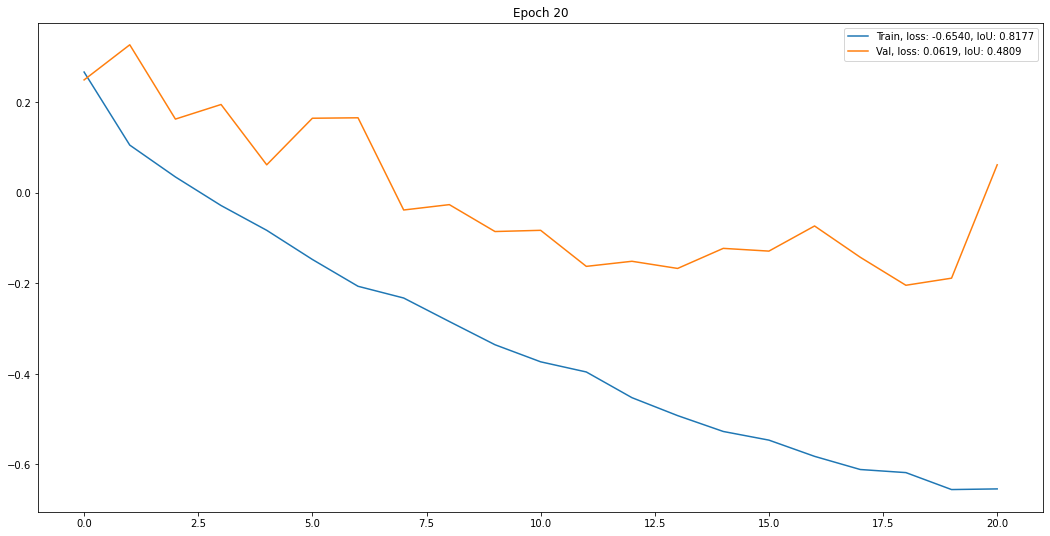

 Epoch: 21 of 100, Iter.: 44 of 44, Loss: -0.674905, Val. Loss: -0.194580
 Epoch: 21 of 100, Iter.: 44 of 44, IoU: 0.826415, Val. IoU: 0.560974


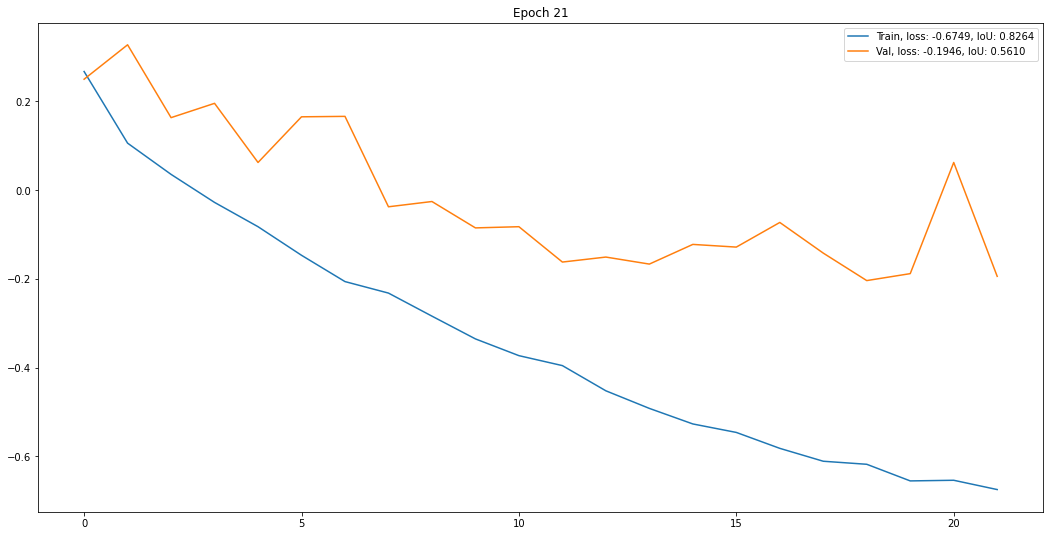

 Epoch: 22 of 100, Iter.: 44 of 44, Loss: -0.709542, Val. Loss: 0.010766
 Epoch: 22 of 100, Iter.: 44 of 44, IoU: 0.846560, Val. IoU: 0.510919


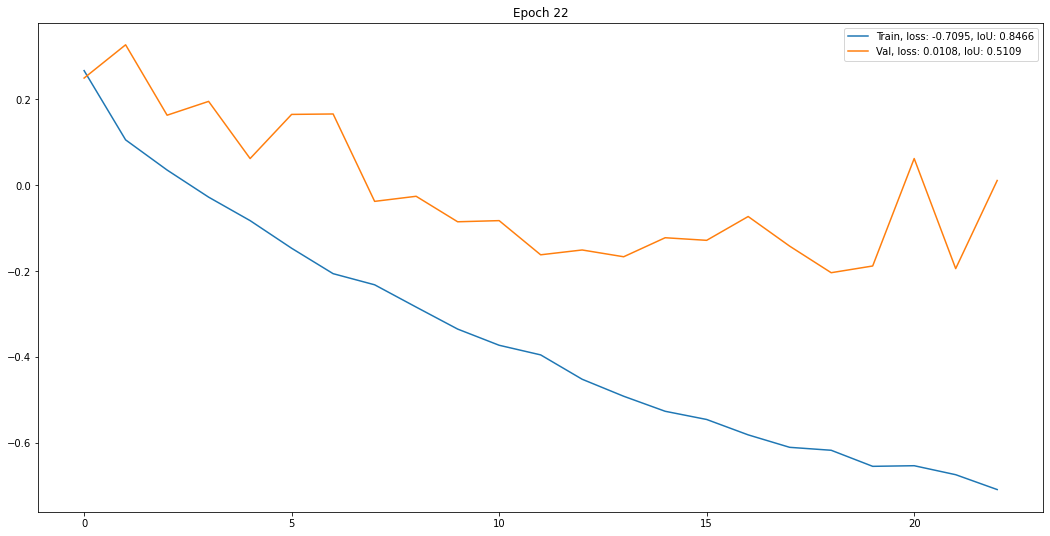

 Epoch: 23 of 100, Iter.: 44 of 44, Loss: -0.712639, Val. Loss: -0.222310
 Epoch: 23 of 100, Iter.: 44 of 44, IoU: 0.844238, Val. IoU: 0.576451


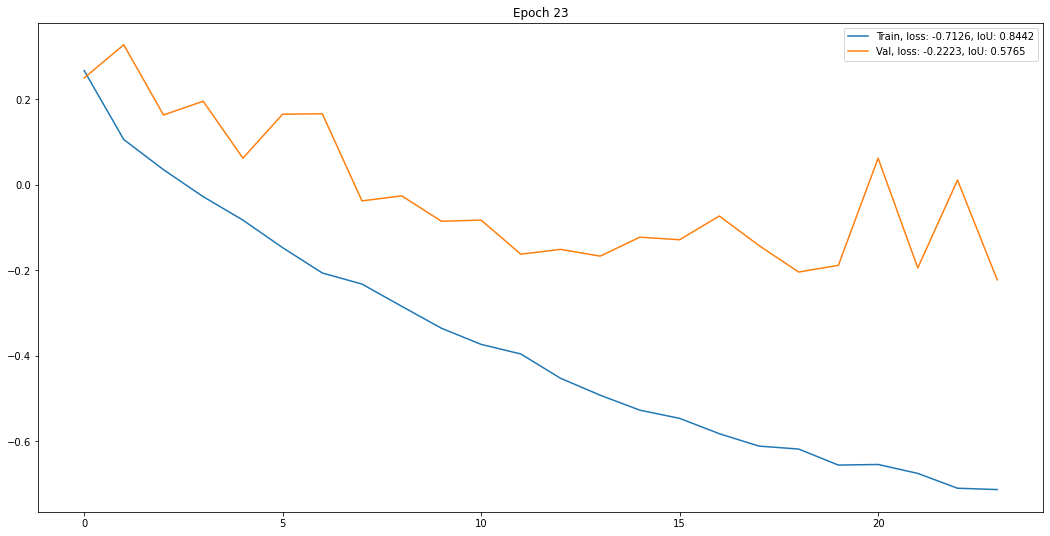

 Epoch: 24 of 100, Iter.: 44 of 44, Loss: -0.732191, Val. Loss: -0.223804
 Epoch: 24 of 100, Iter.: 44 of 44, IoU: 0.851256, Val. IoU: 0.607140


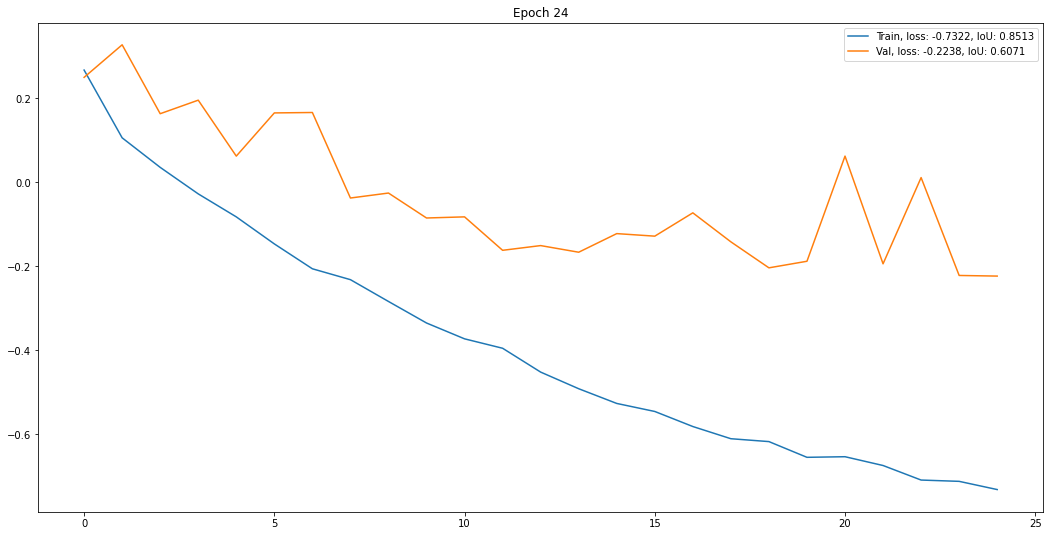

 Epoch: 25 of 100, Iter.: 44 of 44, Loss: -0.749853, Val. Loss: -0.231010
 Epoch: 25 of 100, Iter.: 44 of 44, IoU: 0.859923, Val. IoU: 0.586535


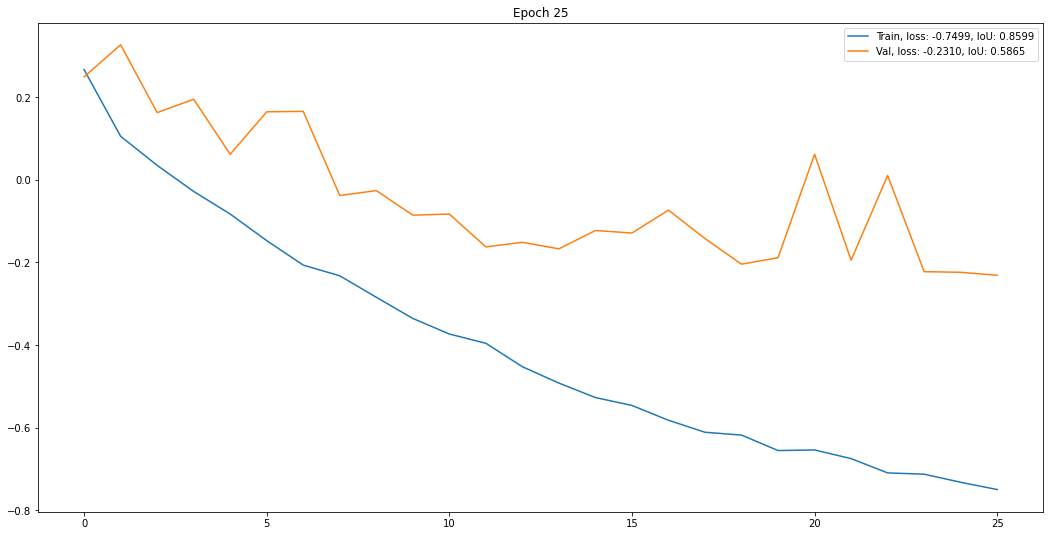

 Epoch: 26 of 100, Iter.: 44 of 44, Loss: -0.761613, Val. Loss: -0.200238
 Epoch: 26 of 100, Iter.: 44 of 44, IoU: 0.867456, Val. IoU: 0.576480


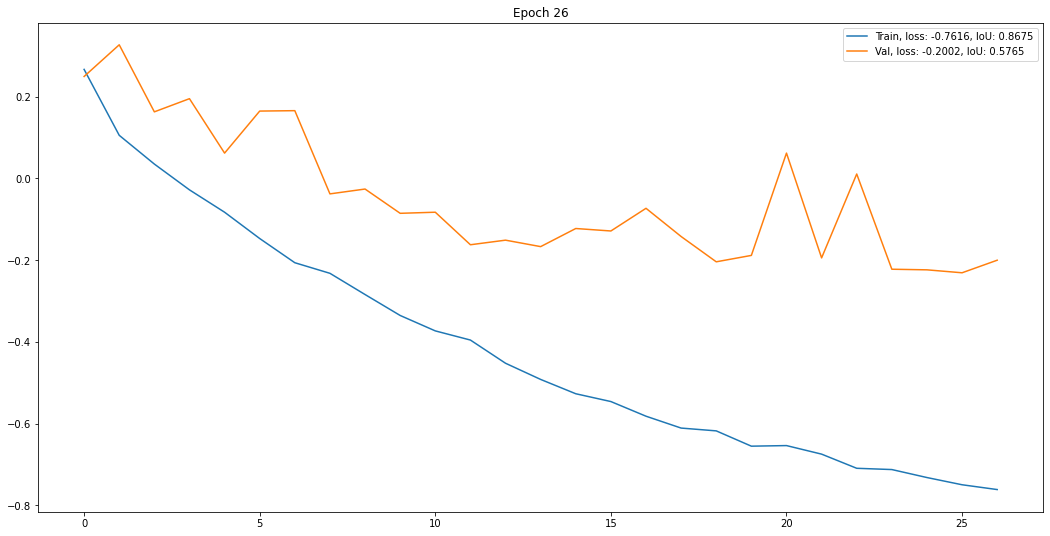

 Epoch: 27 of 100, Iter.: 44 of 44, Loss: -0.775872, Val. Loss: -0.258033
 Epoch: 27 of 100, Iter.: 44 of 44, IoU: 0.871350, Val. IoU: 0.591800


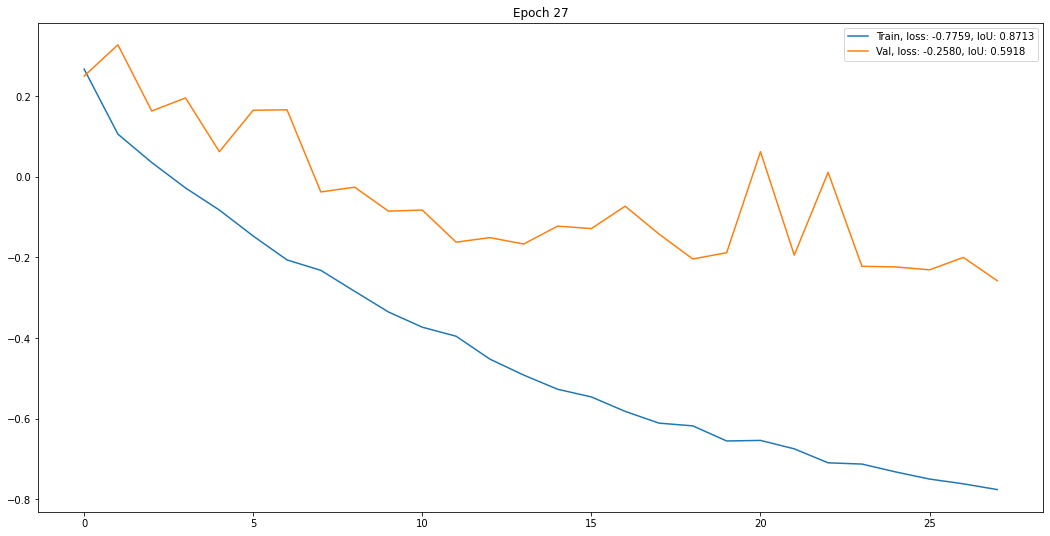

 Epoch: 28 of 100, Iter.: 44 of 44, Loss: -0.800240, Val. Loss: -0.283392
 Epoch: 28 of 100, Iter.: 44 of 44, IoU: 0.887898, Val. IoU: 0.632662


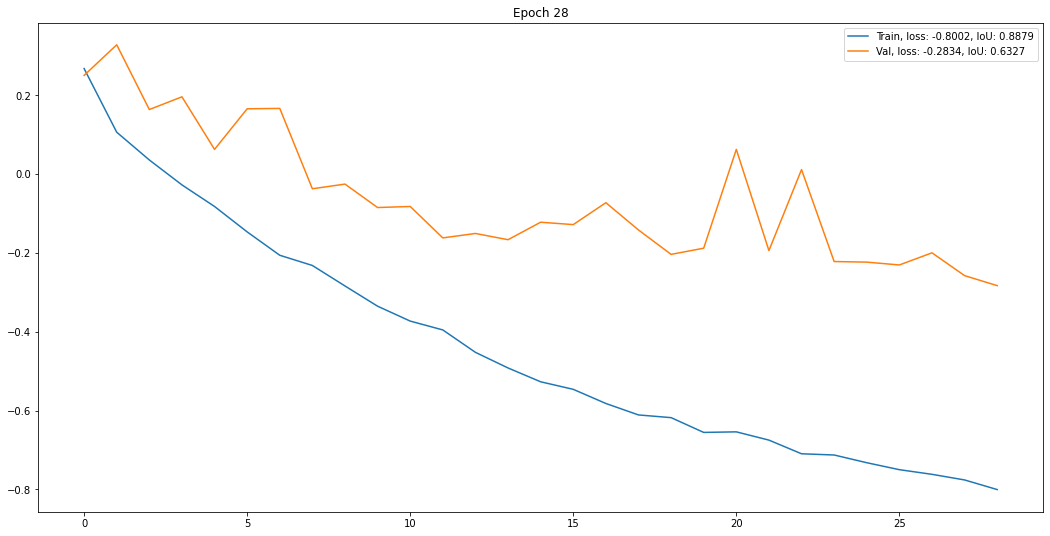

 Epoch: 29 of 100, Iter.: 44 of 44, Loss: -0.803960, Val. Loss: -0.181353
 Epoch: 29 of 100, Iter.: 44 of 44, IoU: 0.886794, Val. IoU: 0.584355


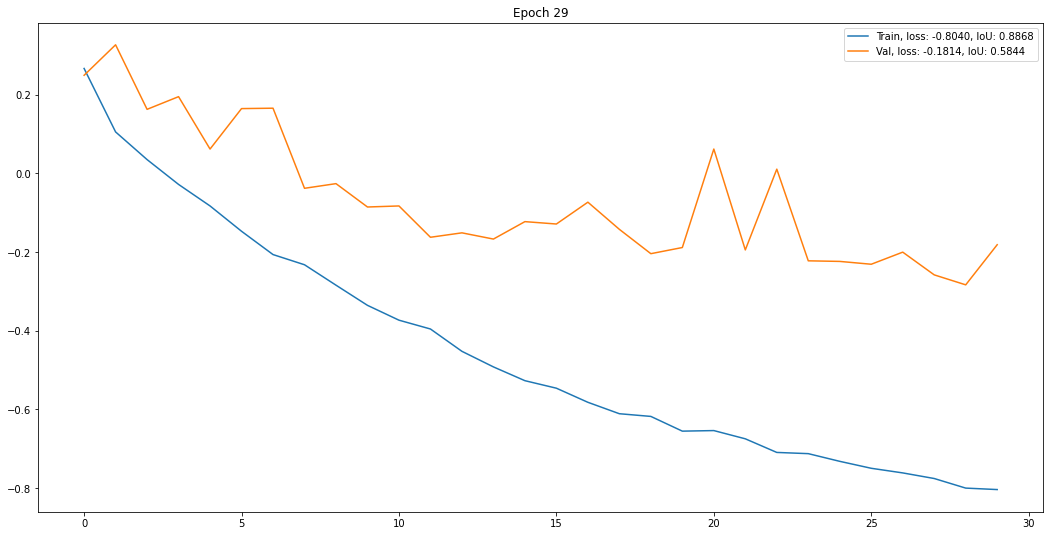

 Epoch: 30 of 100, Iter.: 44 of 44, Loss: -0.803214, Val. Loss: -0.244378
 Epoch: 30 of 100, Iter.: 44 of 44, IoU: 0.883464, Val. IoU: 0.611960


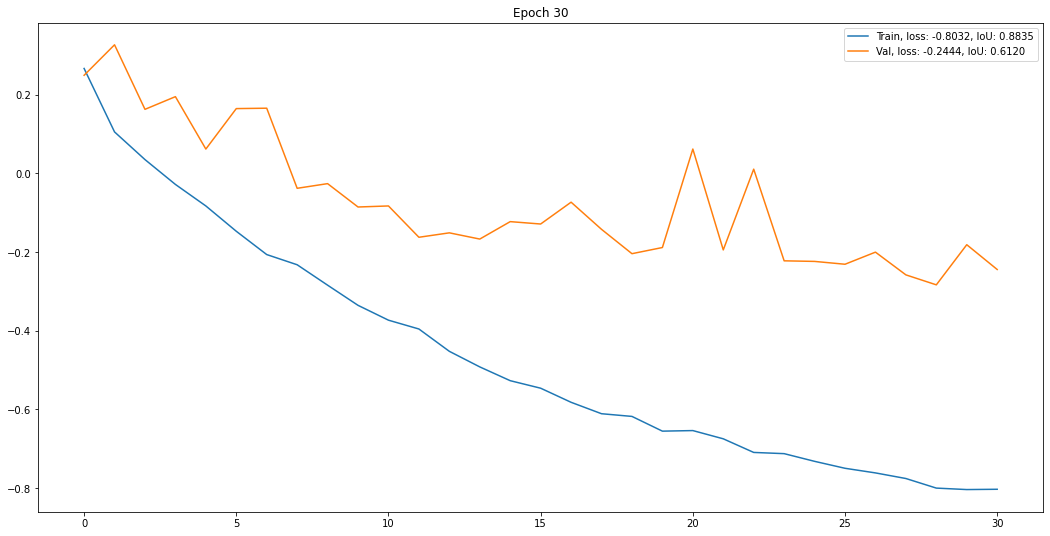

 Epoch: 31 of 100, Iter.: 44 of 44, Loss: -0.815015, Val. Loss: -0.238740
 Epoch: 31 of 100, Iter.: 44 of 44, IoU: 0.886391, Val. IoU: 0.602753


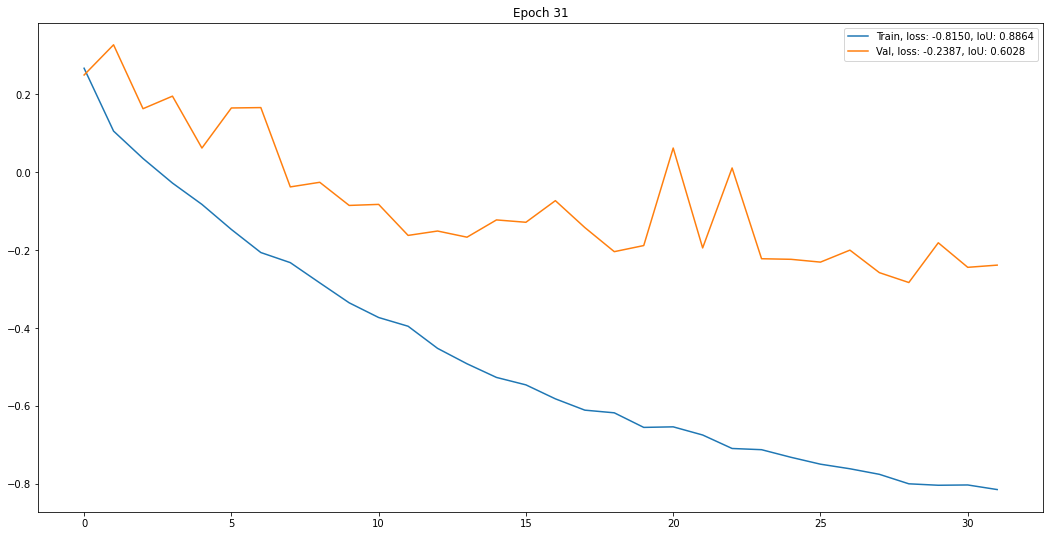

 Epoch: 32 of 100, Iter.: 44 of 44, Loss: -0.829605, Val. Loss: -0.236925
 Epoch: 32 of 100, Iter.: 44 of 44, IoU: 0.895136, Val. IoU: 0.615074


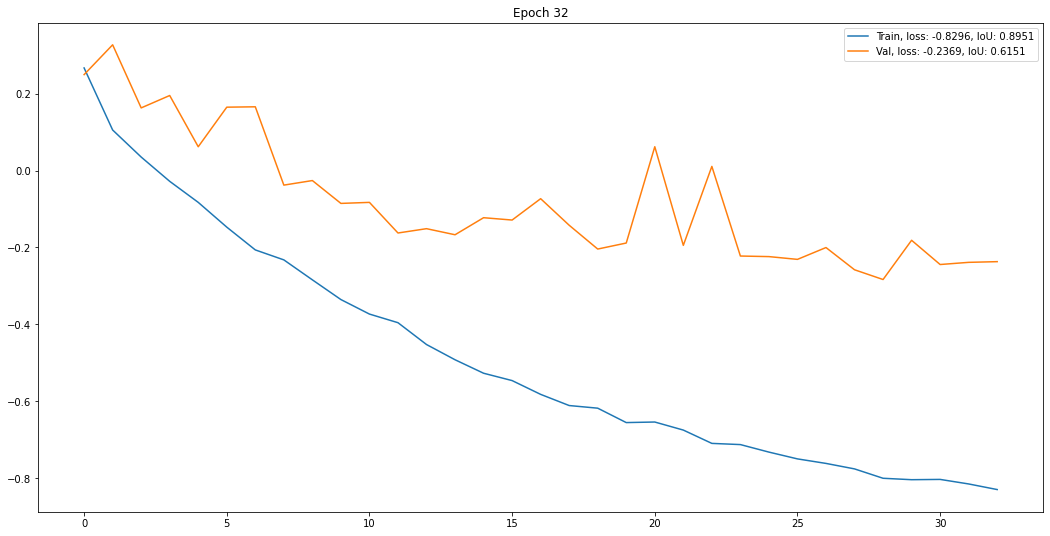

 Epoch: 33 of 100, Iter.: 44 of 44, Loss: -0.839387, Val. Loss: -0.285372
 Epoch: 33 of 100, Iter.: 44 of 44, IoU: 0.900218, Val. IoU: 0.642396


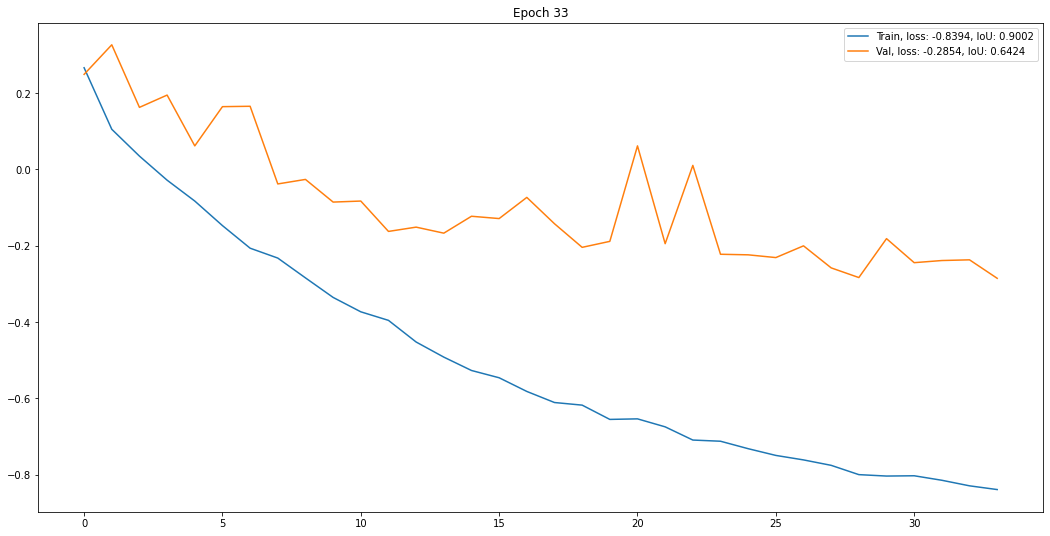

 Epoch: 34 of 100, Iter.: 44 of 44, Loss: -0.845672, Val. Loss: -0.246026
 Epoch: 34 of 100, Iter.: 44 of 44, IoU: 0.904061, Val. IoU: 0.626236


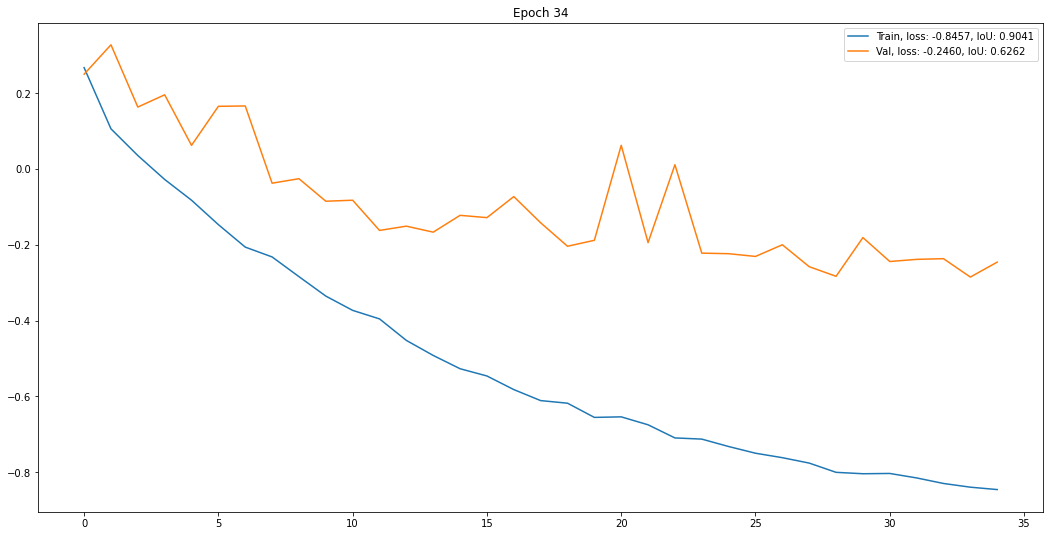

 Epoch: 35 of 100, Iter.: 44 of 44, Loss: -0.856306, Val. Loss: -0.226977
 Epoch: 35 of 100, Iter.: 44 of 44, IoU: 0.910067, Val. IoU: 0.619188


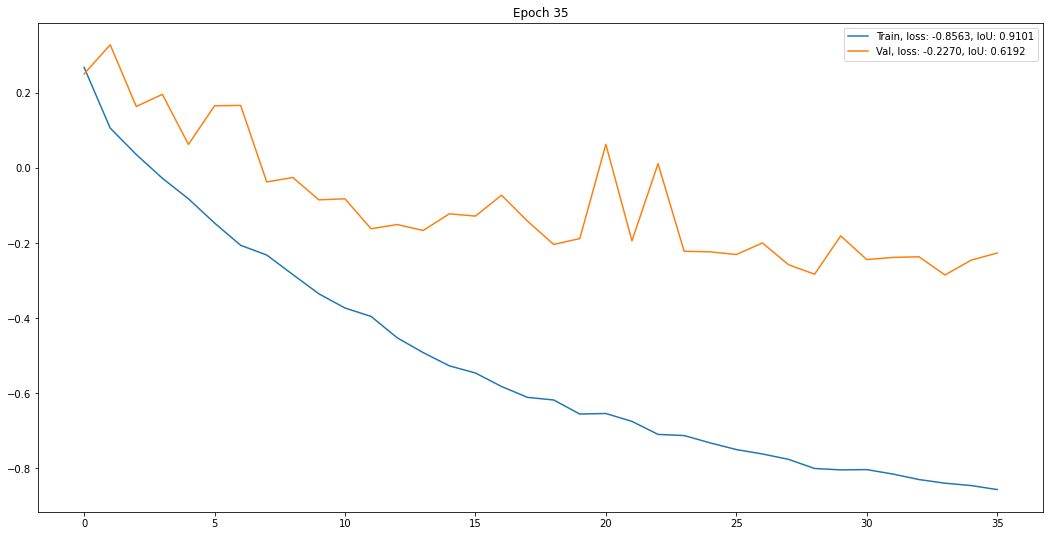

 Epoch: 36 of 100, Iter.: 44 of 44, Loss: -0.856426, Val. Loss: -0.240882
 Epoch: 36 of 100, Iter.: 44 of 44, IoU: 0.908370, Val. IoU: 0.629786


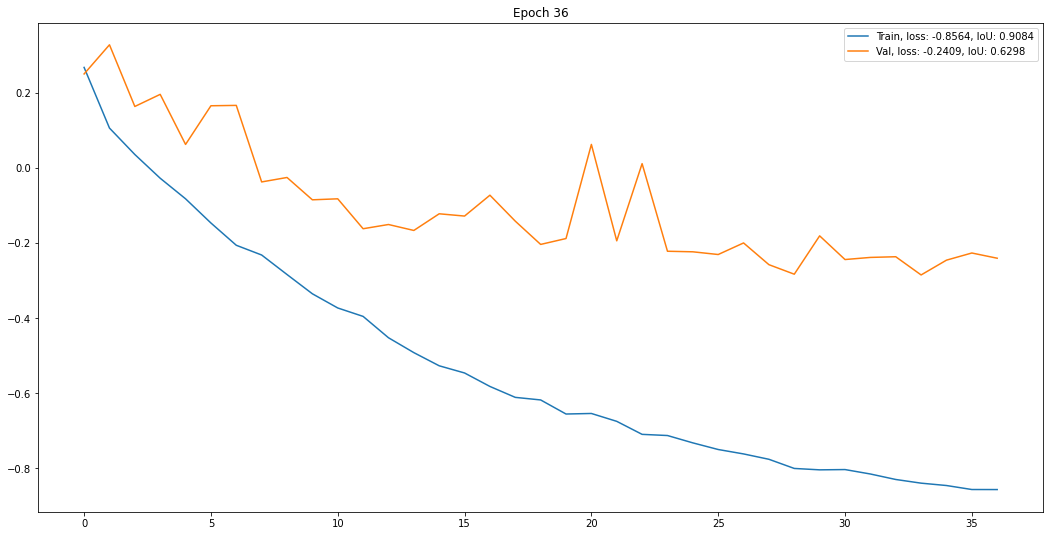

 Epoch: 37 of 100, Iter.: 44 of 44, Loss: -0.863340, Val. Loss: -0.211242
 Epoch: 37 of 100, Iter.: 44 of 44, IoU: 0.912079, Val. IoU: 0.601855


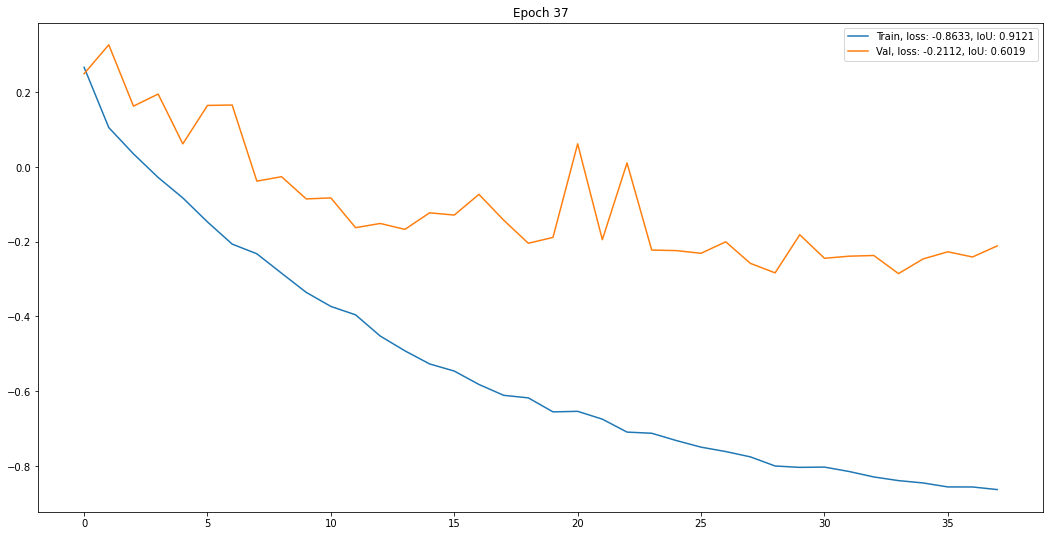

 Epoch: 38 of 100, Iter.: 44 of 44, Loss: -0.867159, Val. Loss: -0.227913
 Epoch: 38 of 100, Iter.: 44 of 44, IoU: 0.913050, Val. IoU: 0.626473


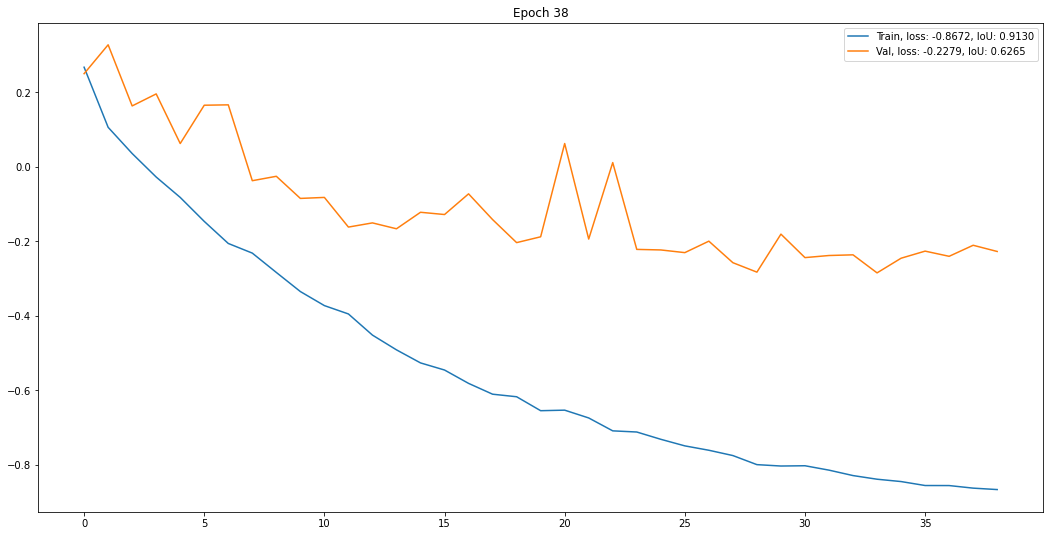

 Epoch: 39 of 100, Iter.: 44 of 44, Loss: -0.861407, Val. Loss: -0.154430
 Epoch: 39 of 100, Iter.: 44 of 44, IoU: 0.906960, Val. IoU: 0.593465


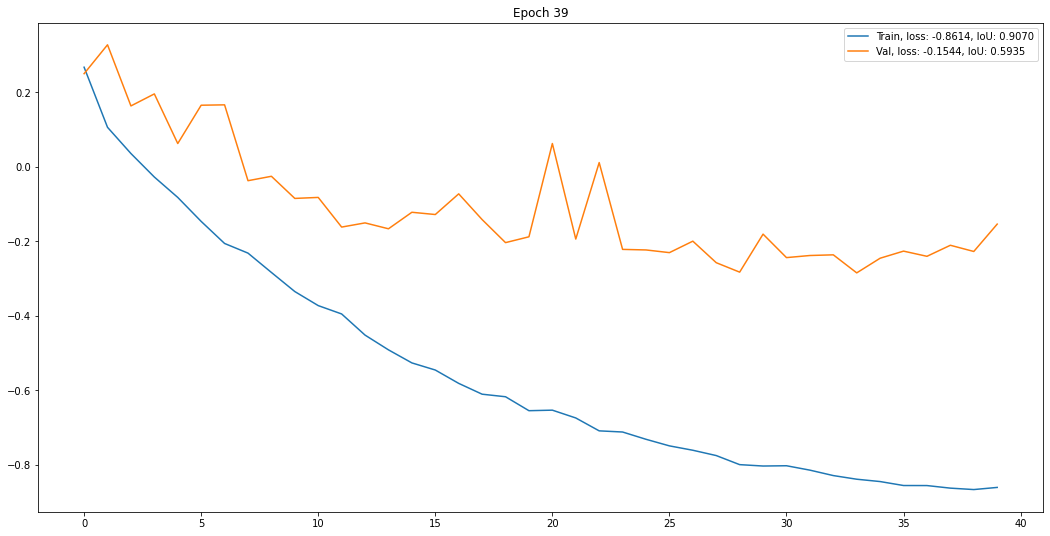

 Epoch: 40 of 100, Iter.: 44 of 44, Loss: -0.831958, Val. Loss: -0.142945
 Epoch: 40 of 100, Iter.: 44 of 44, IoU: 0.887317, Val. IoU: 0.578443


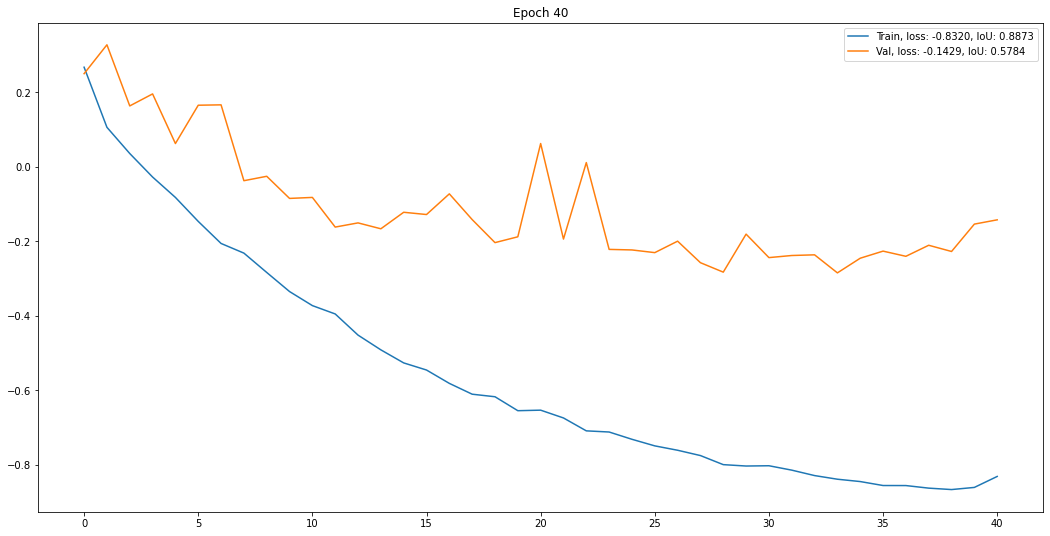

 Epoch: 41 of 100, Iter.: 44 of 44, Loss: -0.843002, Val. Loss: -0.257296
 Epoch: 41 of 100, Iter.: 44 of 44, IoU: 0.892035, Val. IoU: 0.642027


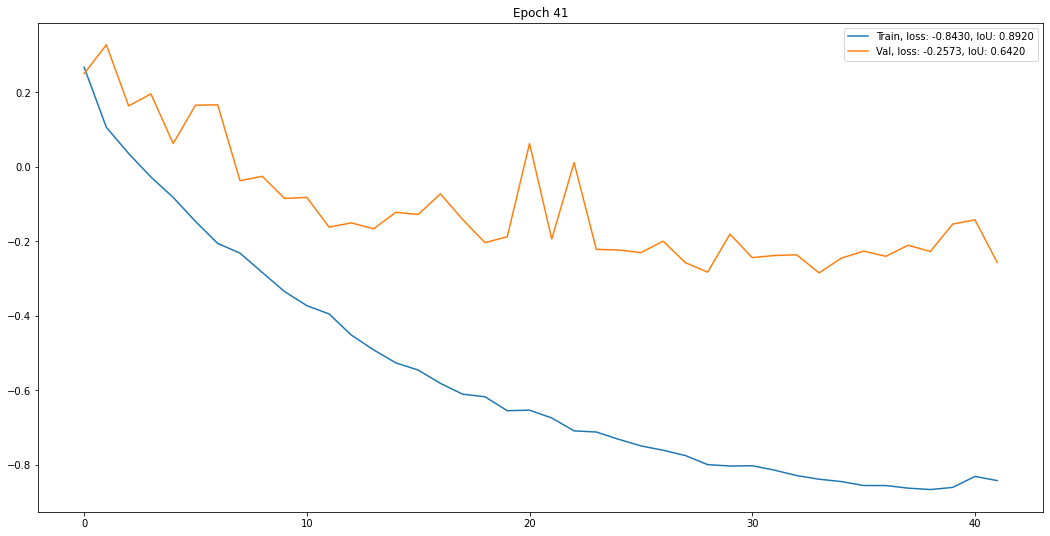

 Epoch: 42 of 100, Iter.: 44 of 44, Loss: -0.854037, Val. Loss: -0.232957
 Epoch: 42 of 100, Iter.: 44 of 44, IoU: 0.900638, Val. IoU: 0.645684


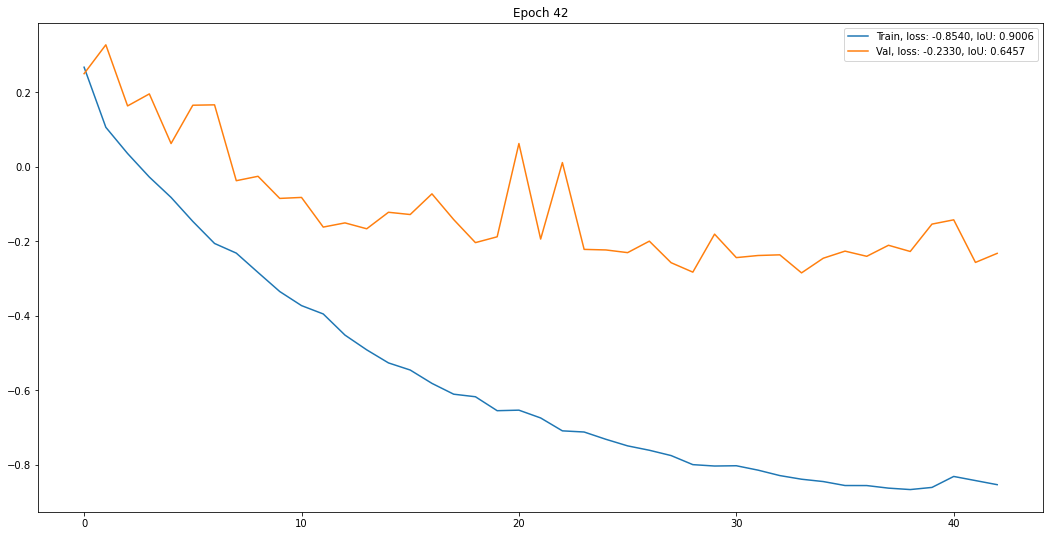

 Epoch: 43 of 100, Iter.: 44 of 44, Loss: -0.866777, Val. Loss: -0.258089
 Epoch: 43 of 100, Iter.: 44 of 44, IoU: 0.908617, Val. IoU: 0.647111


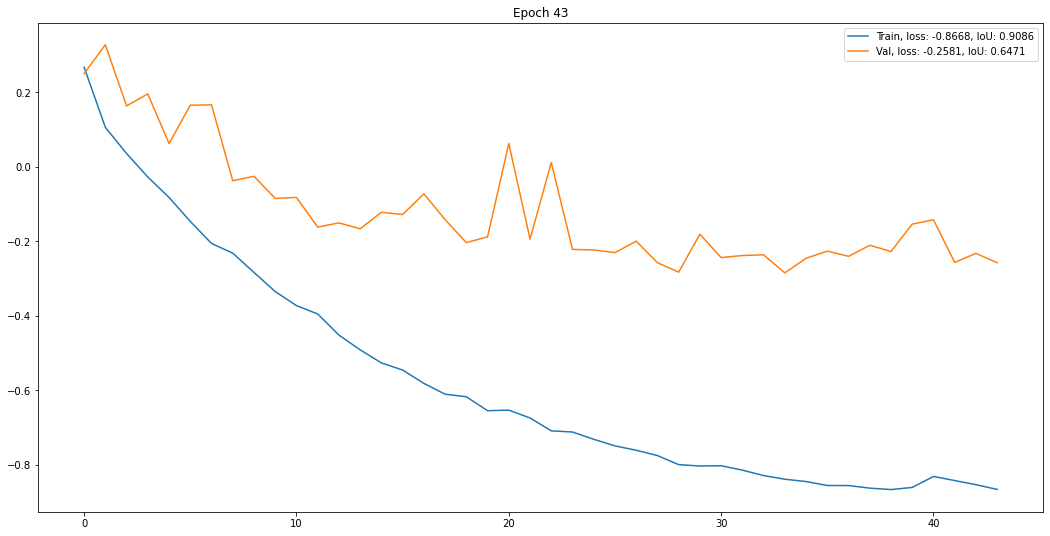

 Epoch: 44 of 100, Iter.: 44 of 44, Loss: -0.863835, Val. Loss: -0.218712
 Epoch: 44 of 100, Iter.: 44 of 44, IoU: 0.904251, Val. IoU: 0.622154


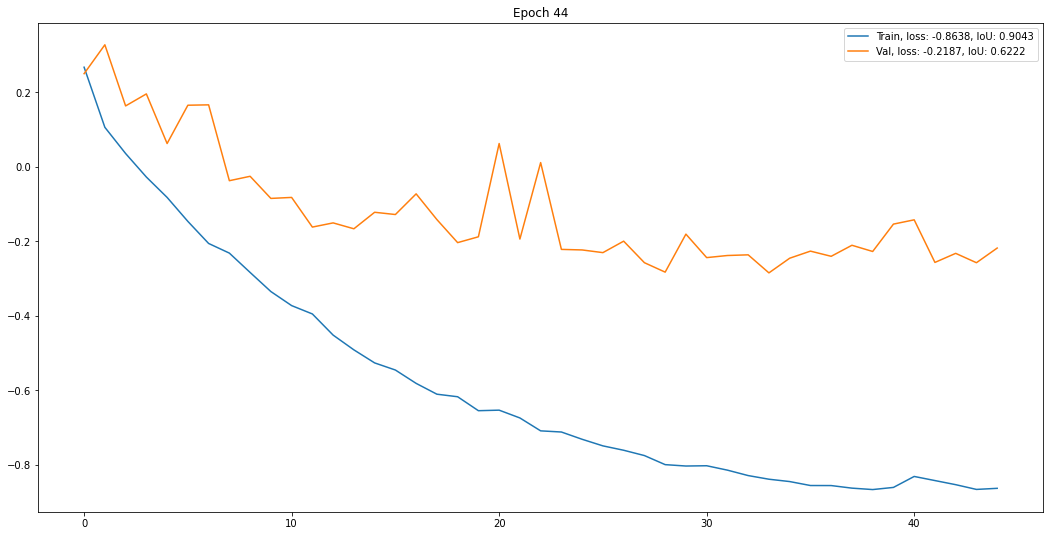

 Epoch: 45 of 100, Iter.: 44 of 44, Loss: -0.876893, Val. Loss: -0.215268
 Epoch: 45 of 100, Iter.: 44 of 44, IoU: 0.913669, Val. IoU: 0.614340


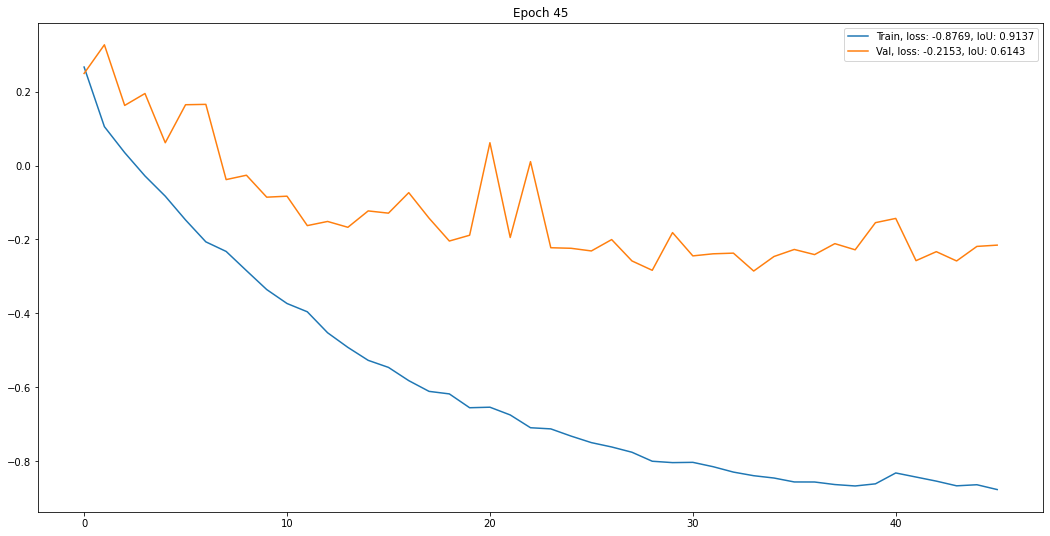

 Epoch: 46 of 100, Iter.: 44 of 44, Loss: -0.862874, Val. Loss: -0.229357
 Epoch: 46 of 100, Iter.: 44 of 44, IoU: 0.905947, Val. IoU: 0.619165


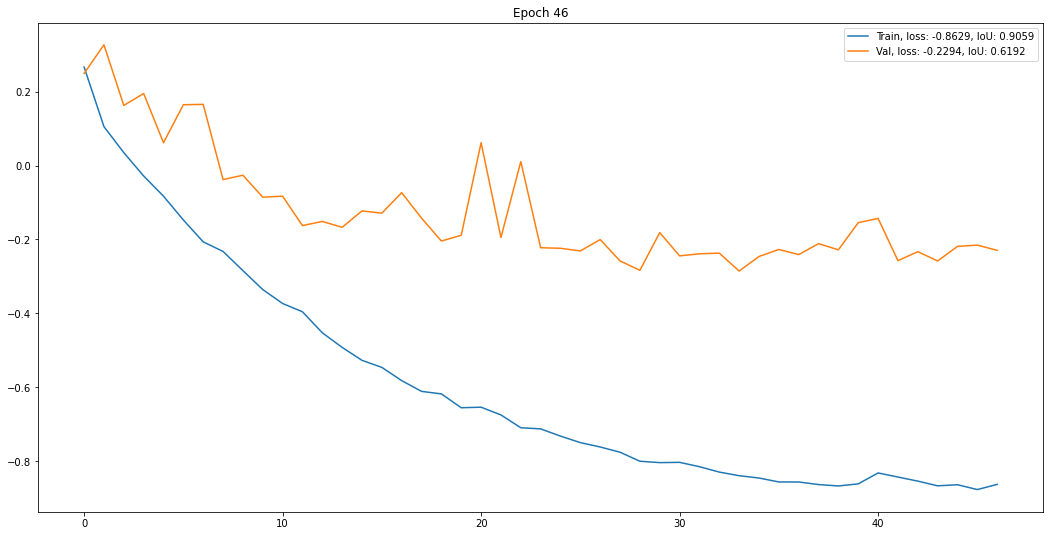

 Epoch: 47 of 100, Iter.: 44 of 44, Loss: -0.883082, Val. Loss: -0.225294
 Epoch: 47 of 100, Iter.: 44 of 44, IoU: 0.918887, Val. IoU: 0.620966


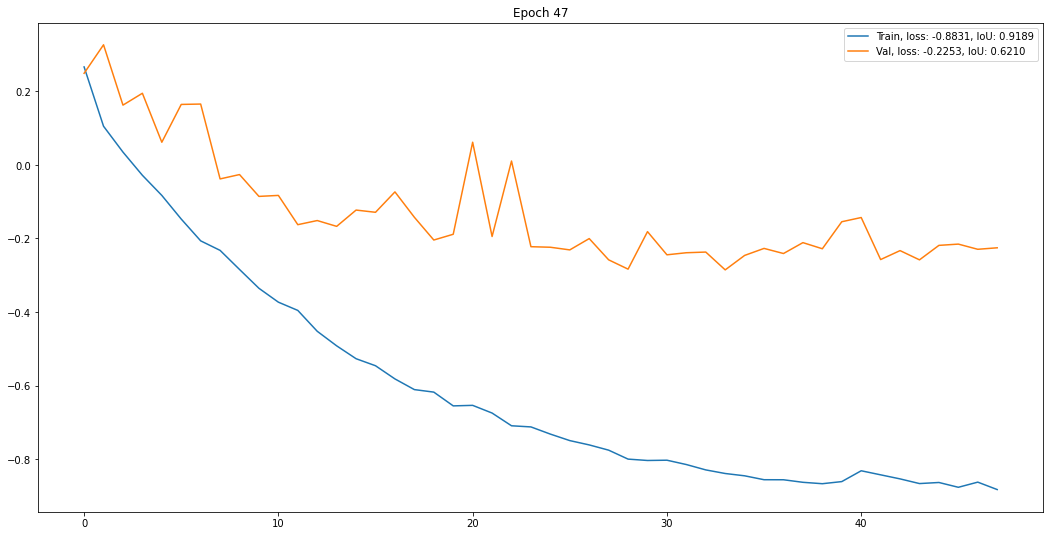

 Epoch: 48 of 100, Iter.: 44 of 44, Loss: -0.891190, Val. Loss: -0.228797
 Epoch: 48 of 100, Iter.: 44 of 44, IoU: 0.924347, Val. IoU: 0.611209


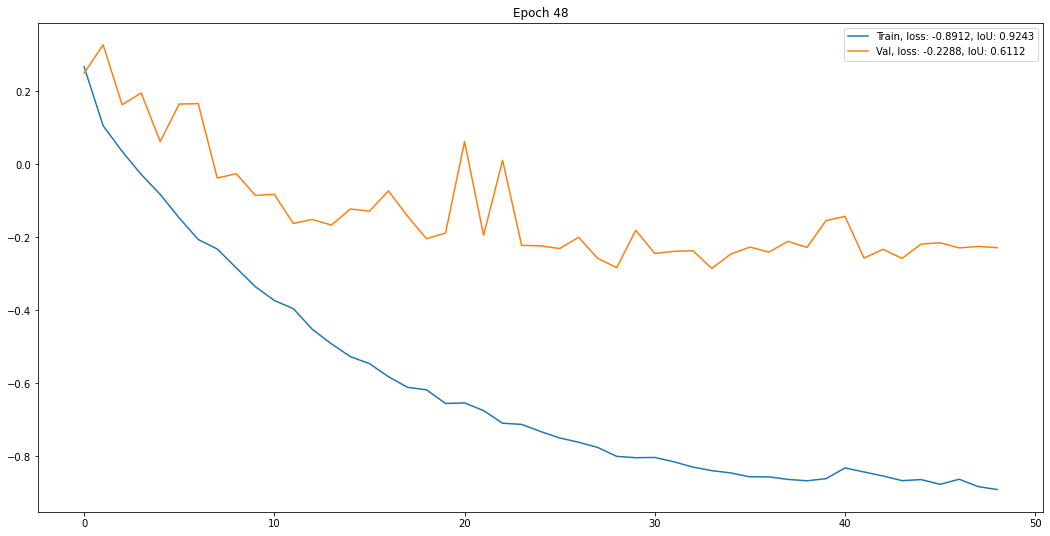

 Epoch: 49 of 100, Iter.: 44 of 44, Loss: -0.904501, Val. Loss: -0.241369
 Epoch: 49 of 100, Iter.: 44 of 44, IoU: 0.932191, Val. IoU: 0.624257


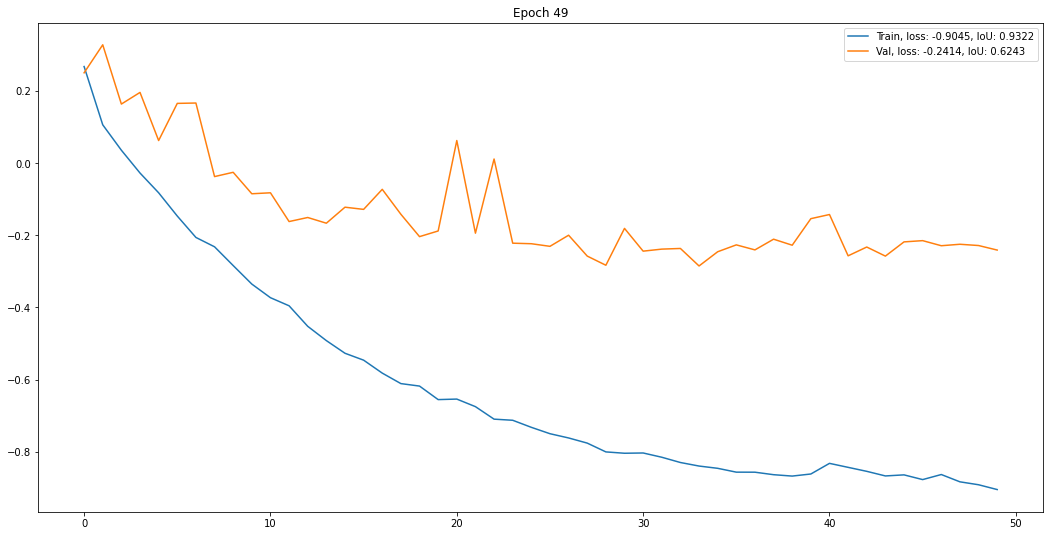

 Epoch: 50 of 100, Iter.: 44 of 44, Loss: -0.911156, Val. Loss: -0.246043
 Epoch: 50 of 100, Iter.: 44 of 44, IoU: 0.939180, Val. IoU: 0.631476


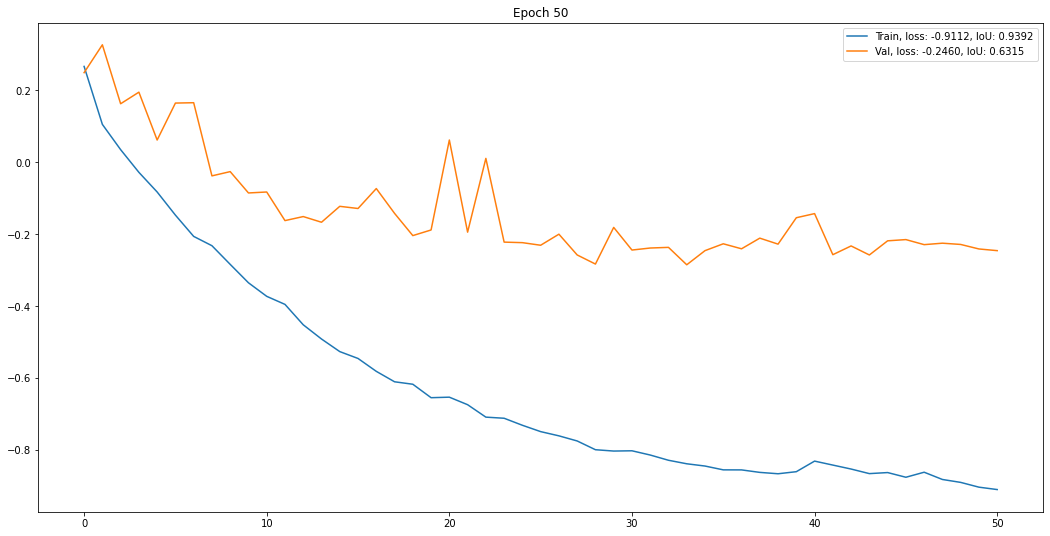

 Epoch: 51 of 100, Iter.: 44 of 44, Loss: -0.915077, Val. Loss: -0.240741
 Epoch: 51 of 100, Iter.: 44 of 44, IoU: 0.942215, Val. IoU: 0.616478


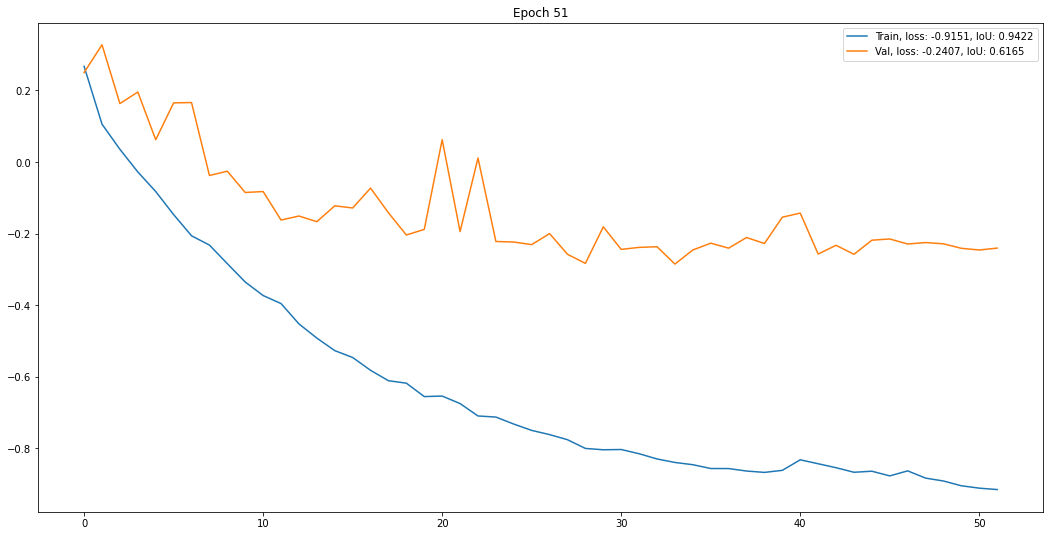

 Epoch: 52 of 100, Iter.: 44 of 44, Loss: -0.915542, Val. Loss: -0.235361
 Epoch: 52 of 100, Iter.: 44 of 44, IoU: 0.941966, Val. IoU: 0.616966


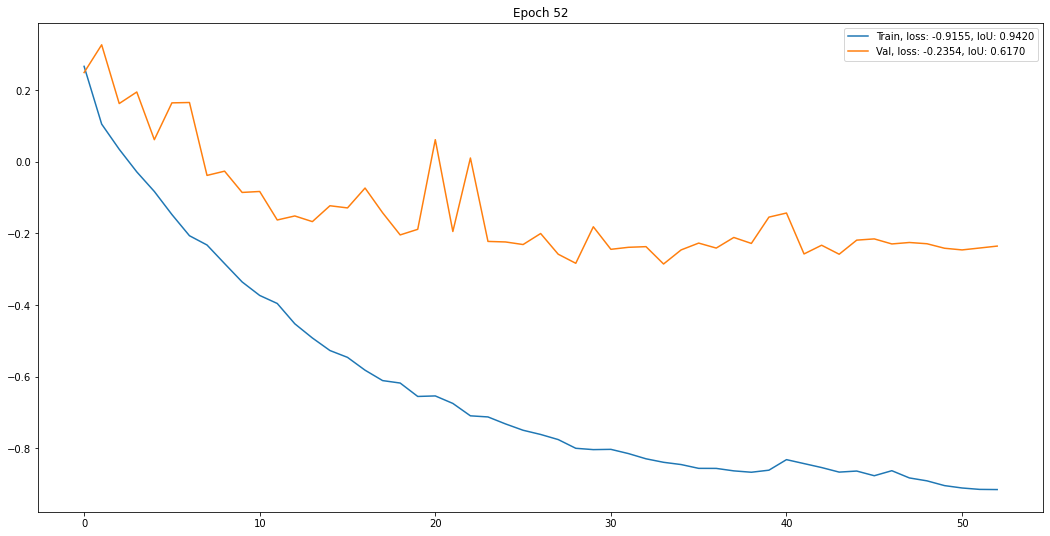

 Epoch: 53 of 100, Iter.: 44 of 44, Loss: -0.916241, Val. Loss: -0.222325
 Epoch: 53 of 100, Iter.: 44 of 44, IoU: 0.941451, Val. IoU: 0.617743


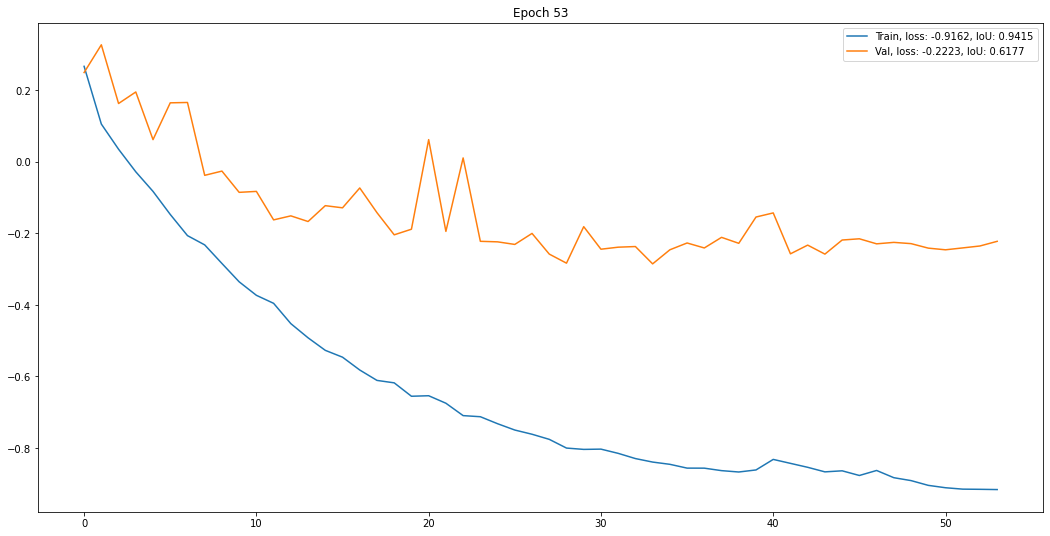

 Epoch: 54 of 100, Iter.: 44 of 44, Loss: -0.918353, Val. Loss: -0.202737
 Epoch: 54 of 100, Iter.: 44 of 44, IoU: 0.943041, Val. IoU: 0.605366


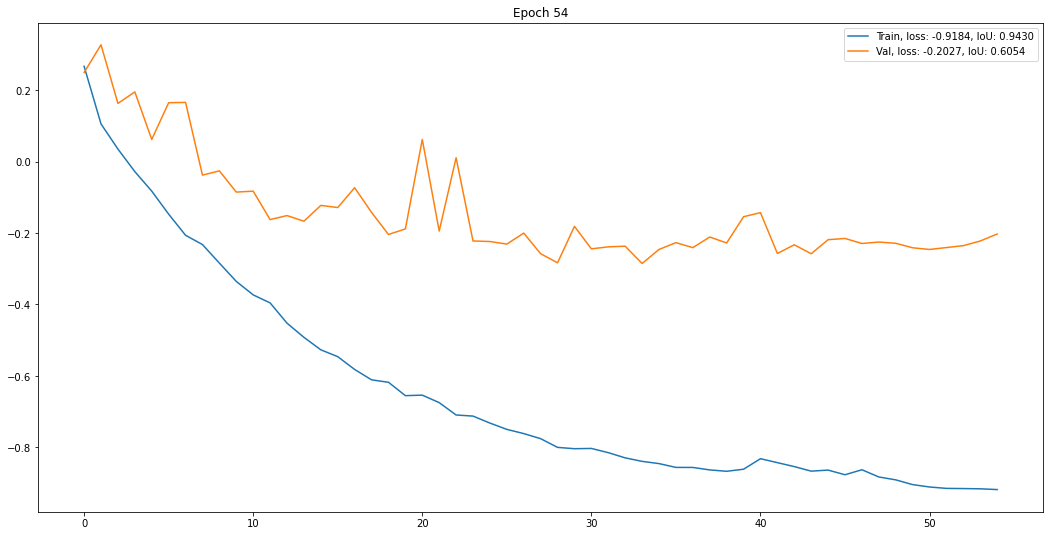

 Epoch: 55 of 100, Iter.: 44 of 44, Loss: -0.920066, Val. Loss: -0.218393
 Epoch: 55 of 100, Iter.: 44 of 44, IoU: 0.943924, Val. IoU: 0.604030


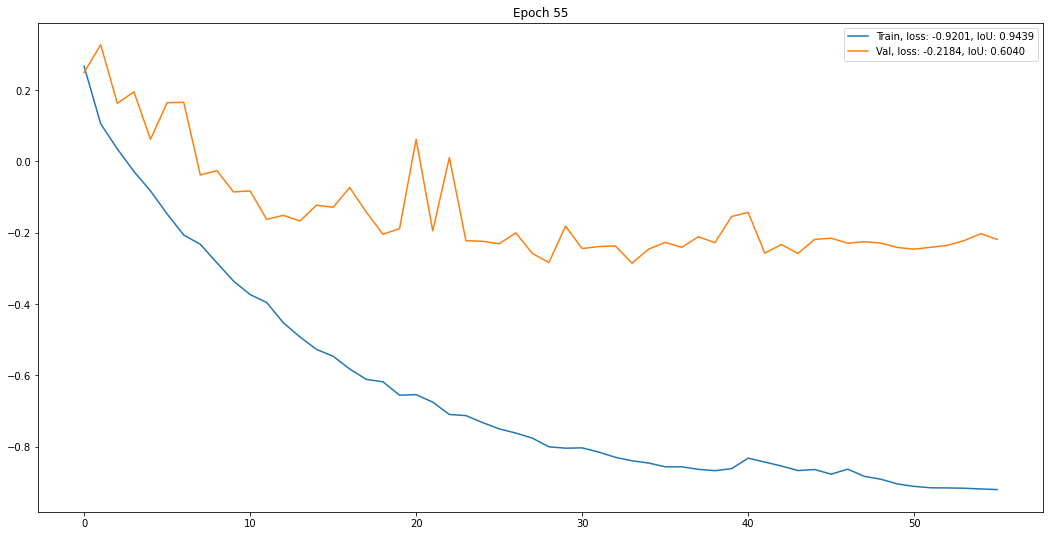

 Epoch: 56 of 100, Iter.: 44 of 44, Loss: -0.924218, Val. Loss: -0.225291
 Epoch: 56 of 100, Iter.: 44 of 44, IoU: 0.946841, Val. IoU: 0.612338


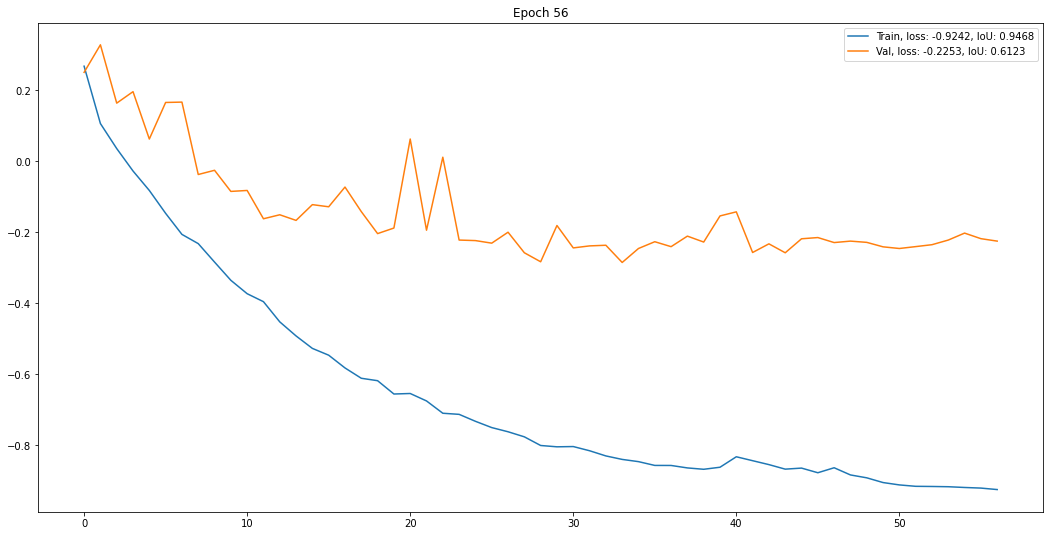

 Epoch: 57 of 100, Iter.: 44 of 44, Loss: -0.925367, Val. Loss: -0.210462
 Epoch: 57 of 100, Iter.: 44 of 44, IoU: 0.947205, Val. IoU: 0.612829


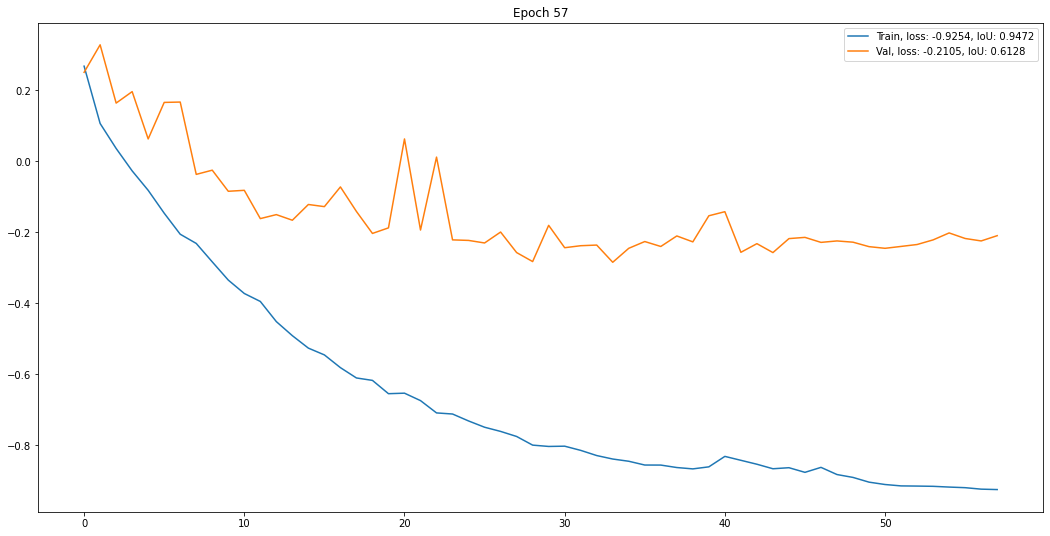

 Epoch: 58 of 100, Iter.: 44 of 44, Loss: -0.921615, Val. Loss: -0.198353
 Epoch: 58 of 100, Iter.: 44 of 44, IoU: 0.943497, Val. IoU: 0.611017


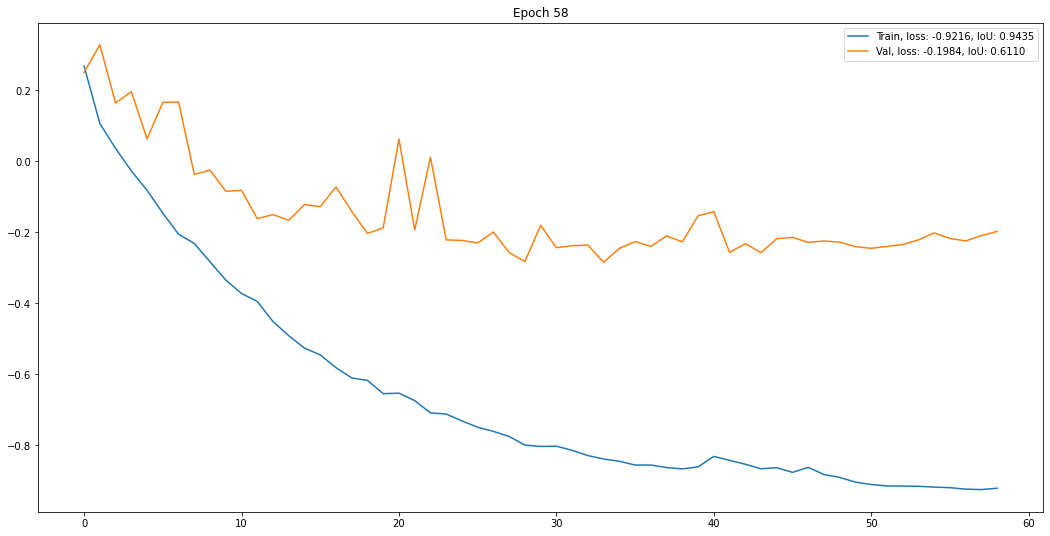

 Epoch: 59 of 100, Iter.: 44 of 44, Loss: -0.924825, Val. Loss: -0.211823
 Epoch: 59 of 100, Iter.: 44 of 44, IoU: 0.944708, Val. IoU: 0.630186


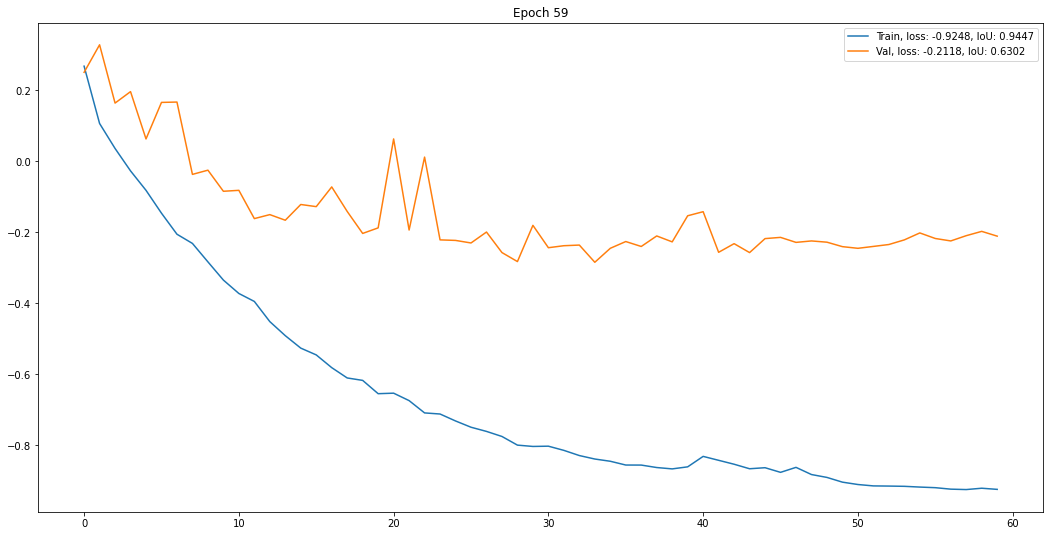

 Epoch: 60 of 100, Iter.: 44 of 44, Loss: -0.927902, Val. Loss: -0.201766
 Epoch: 60 of 100, Iter.: 44 of 44, IoU: 0.946517, Val. IoU: 0.620872


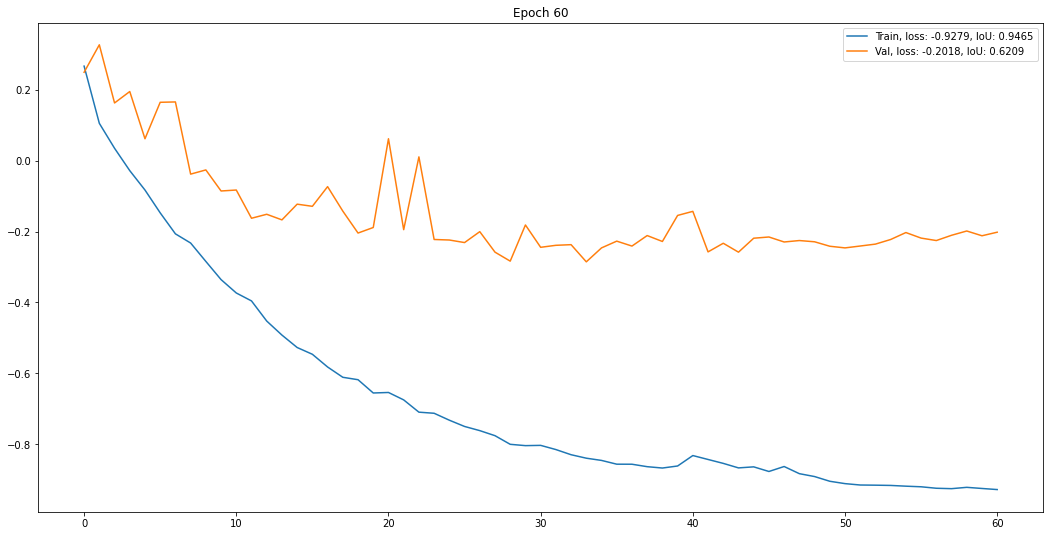

 Epoch: 61 of 100, Iter.: 44 of 44, Loss: -0.928932, Val. Loss: -0.185183
 Epoch: 61 of 100, Iter.: 44 of 44, IoU: 0.947254, Val. IoU: 0.619682


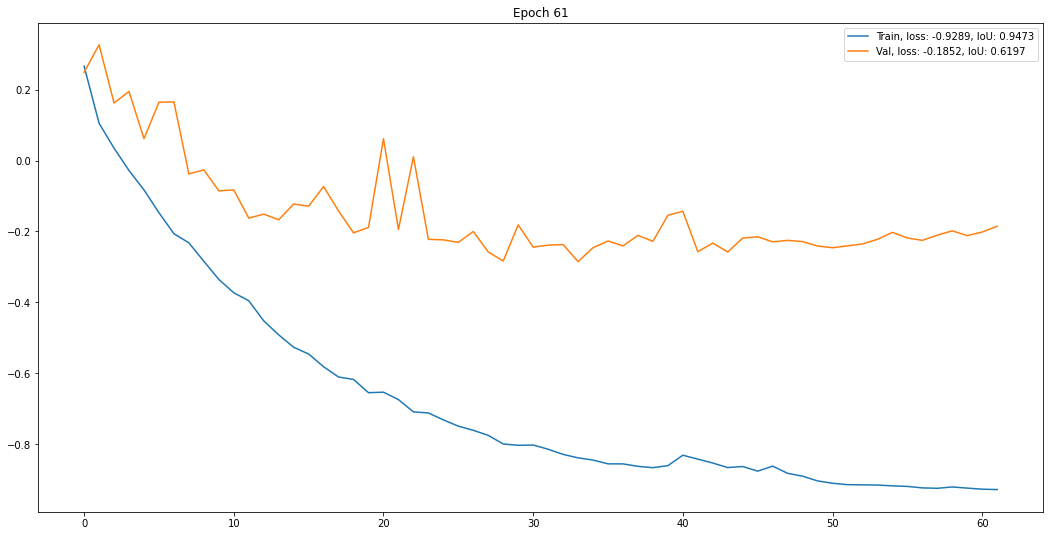

 Epoch: 62 of 100, Iter.: 44 of 44, Loss: -0.929799, Val. Loss: -0.201424
 Epoch: 62 of 100, Iter.: 44 of 44, IoU: 0.947821, Val. IoU: 0.616912


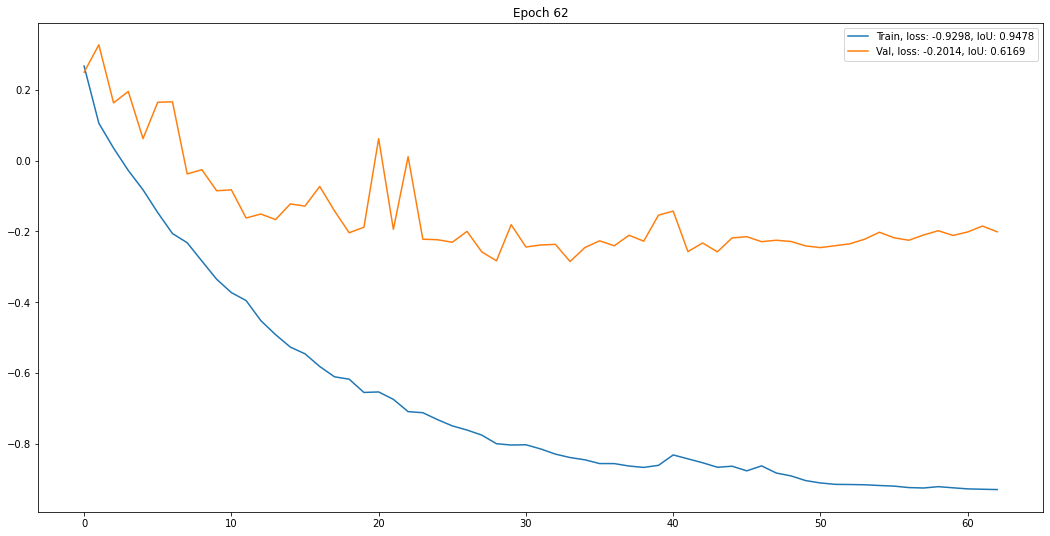

 Epoch: 63 of 100, Iter.: 44 of 44, Loss: -0.930358, Val. Loss: -0.200429
 Epoch: 63 of 100, Iter.: 44 of 44, IoU: 0.948693, Val. IoU: 0.624051


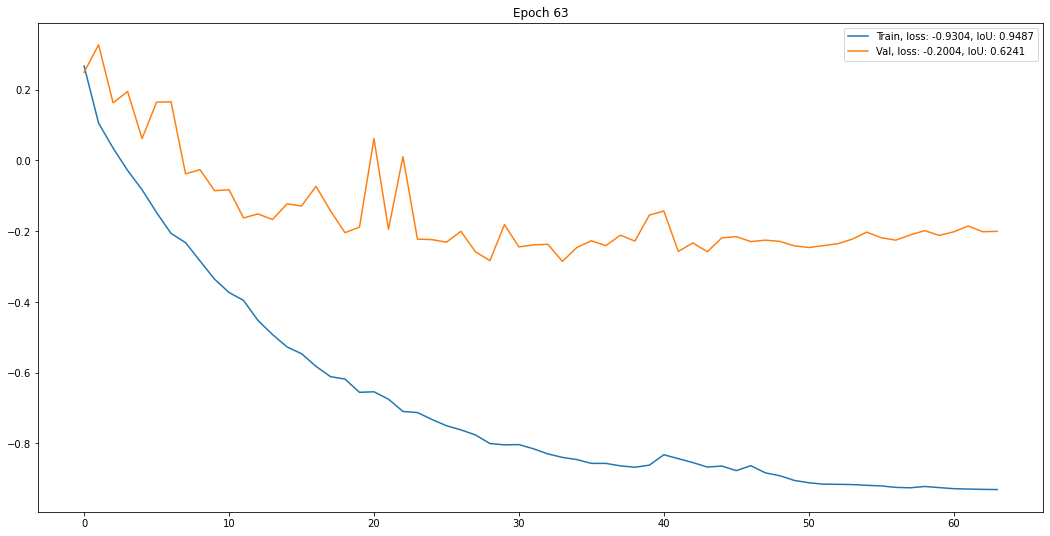

 Epoch: 64 of 100, Iter.: 44 of 44, Loss: -0.929913, Val. Loss: -0.185299
 Epoch: 64 of 100, Iter.: 44 of 44, IoU: 0.947387, Val. IoU: 0.622263


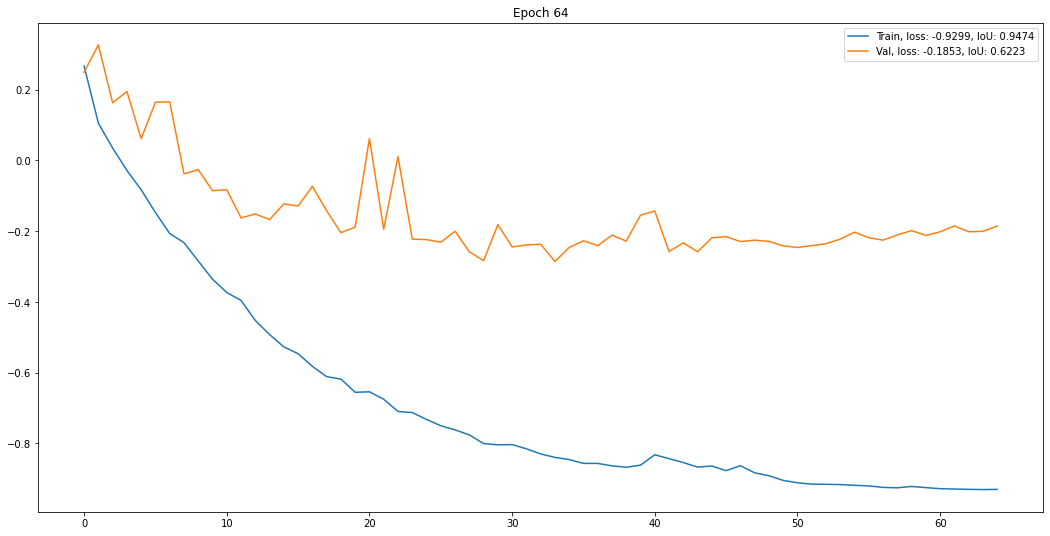

 Epoch: 65 of 100, Iter.: 44 of 44, Loss: -0.929846, Val. Loss: -0.188858
 Epoch: 65 of 100, Iter.: 44 of 44, IoU: 0.947025, Val. IoU: 0.605105


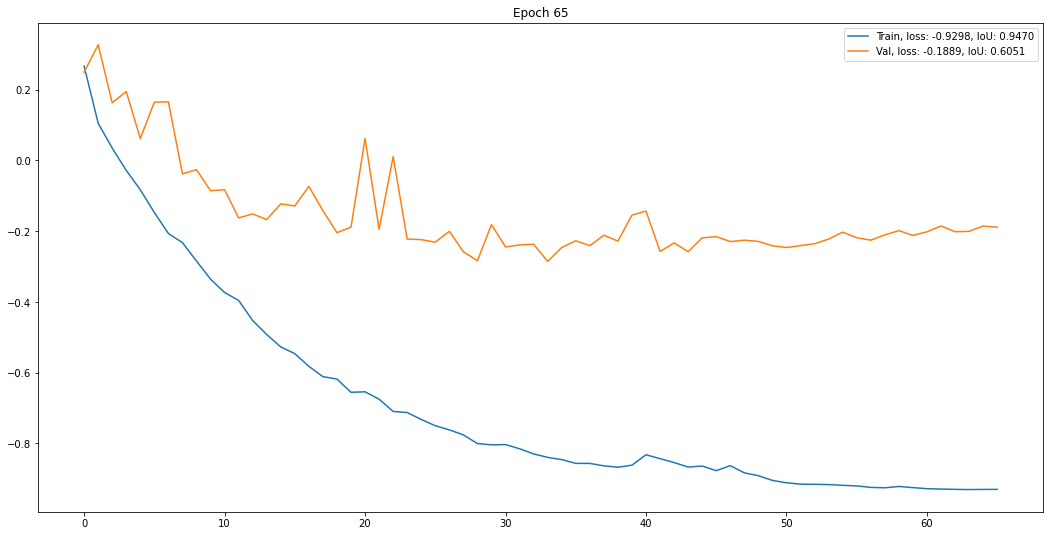

 Epoch: 66 of 100, Iter.: 44 of 44, Loss: -0.932260, Val. Loss: -0.192495
 Epoch: 66 of 100, Iter.: 44 of 44, IoU: 0.949001, Val. IoU: 0.603124


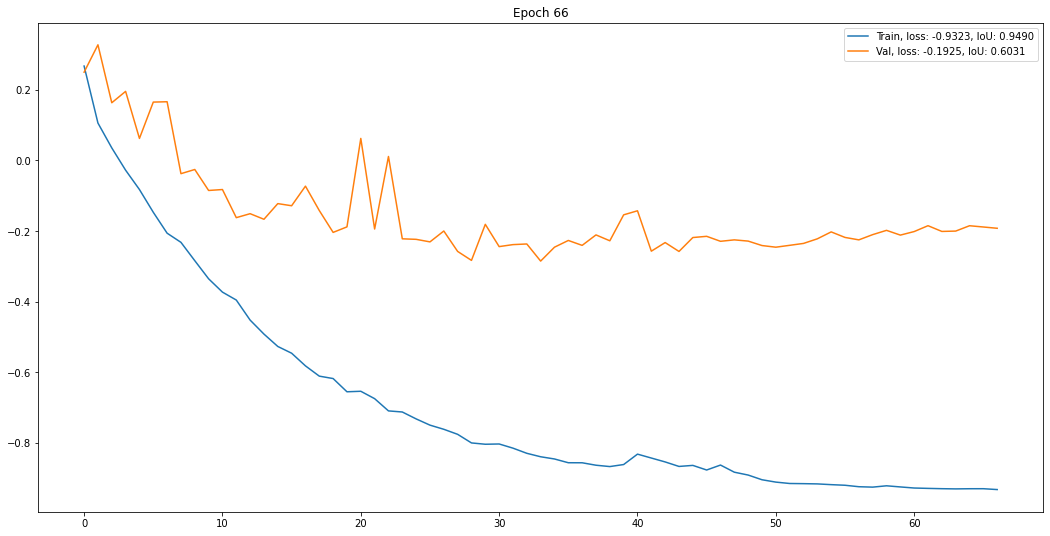

 Epoch: 67 of 100, Iter.: 44 of 44, Loss: -0.935233, Val. Loss: -0.203821
 Epoch: 67 of 100, Iter.: 44 of 44, IoU: 0.950960, Val. IoU: 0.619764


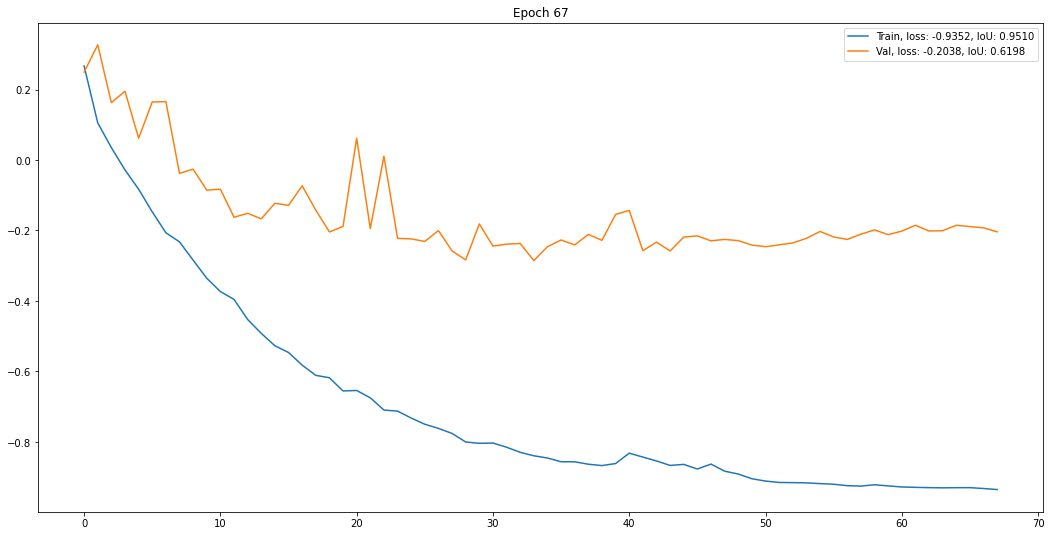

 Epoch: 68 of 100, Iter.: 44 of 44, Loss: -0.939648, Val. Loss: -0.206334
 Epoch: 68 of 100, Iter.: 44 of 44, IoU: 0.954088, Val. IoU: 0.633593


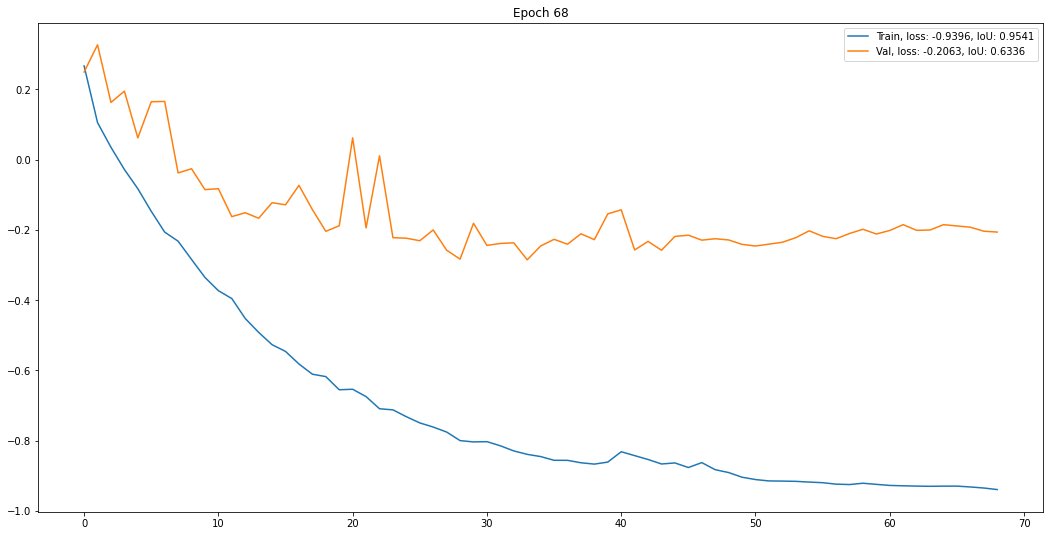

 Epoch: 69 of 100, Iter.: 44 of 44, Loss: -0.942220, Val. Loss: -0.205388
 Epoch: 69 of 100, Iter.: 44 of 44, IoU: 0.955600, Val. IoU: 0.635676


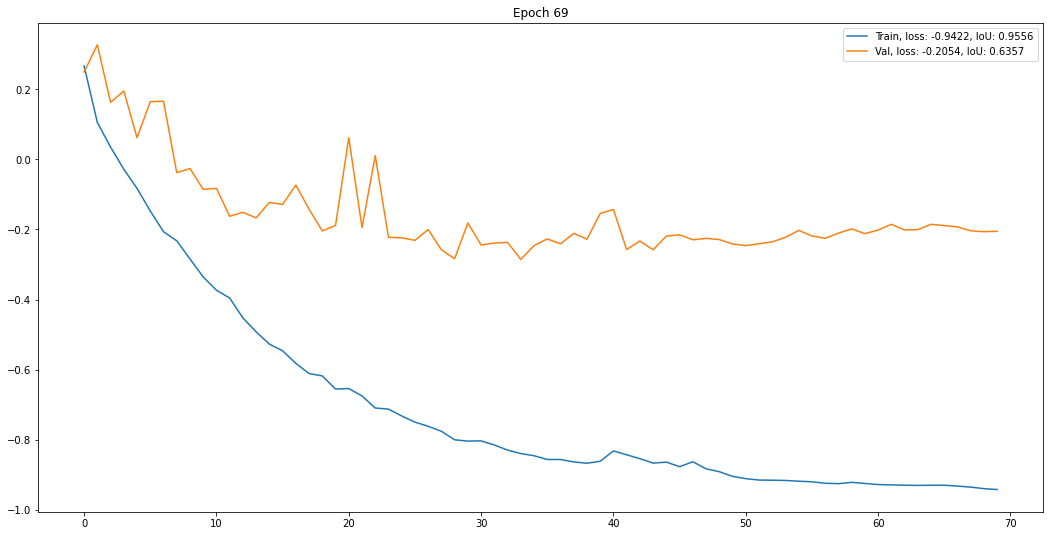

 Epoch: 70 of 100, Iter.: 44 of 44, Loss: -0.943206, Val. Loss: -0.180473
 Epoch: 70 of 100, Iter.: 44 of 44, IoU: 0.956007, Val. IoU: 0.617423


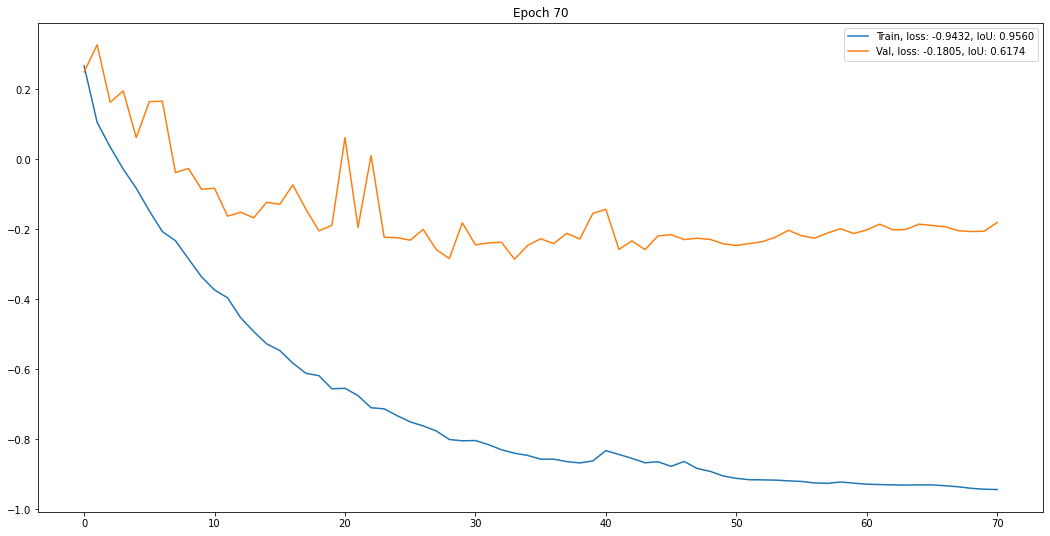

 Epoch: 71 of 100, Iter.: 44 of 44, Loss: -0.941289, Val. Loss: -0.178669
 Epoch: 71 of 100, Iter.: 44 of 44, IoU: 0.954474, Val. IoU: 0.634898


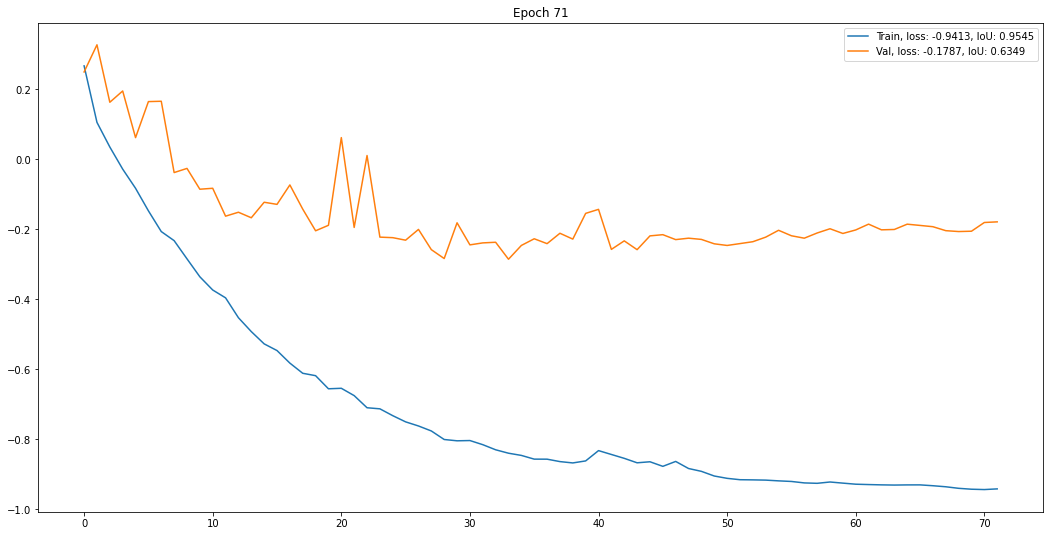

 Epoch: 72 of 100, Iter.: 44 of 44, Loss: -0.939593, Val. Loss: -0.160868
 Epoch: 72 of 100, Iter.: 44 of 44, IoU: 0.953989, Val. IoU: 0.616780


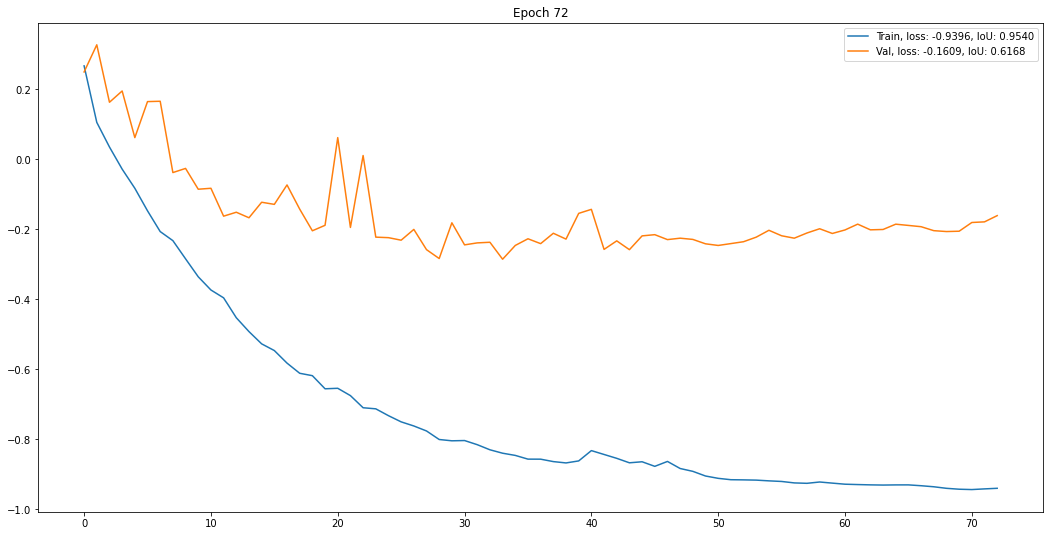

 Epoch: 73 of 100, Iter.: 44 of 44, Loss: -0.919249, Val. Loss: -0.011076
 Epoch: 73 of 100, Iter.: 44 of 44, IoU: 0.934794, Val. IoU: 0.556180


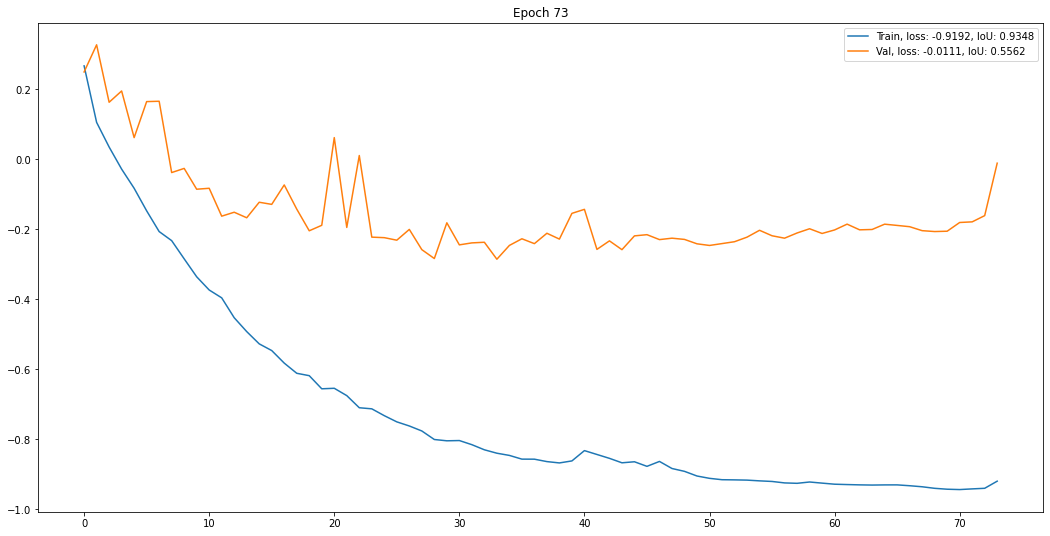

 Epoch: 74 of 100, Iter.: 44 of 44, Loss: -0.737823, Val. Loss: 0.026284
 Epoch: 74 of 100, Iter.: 44 of 44, IoU: 0.825334, Val. IoU: 0.528025


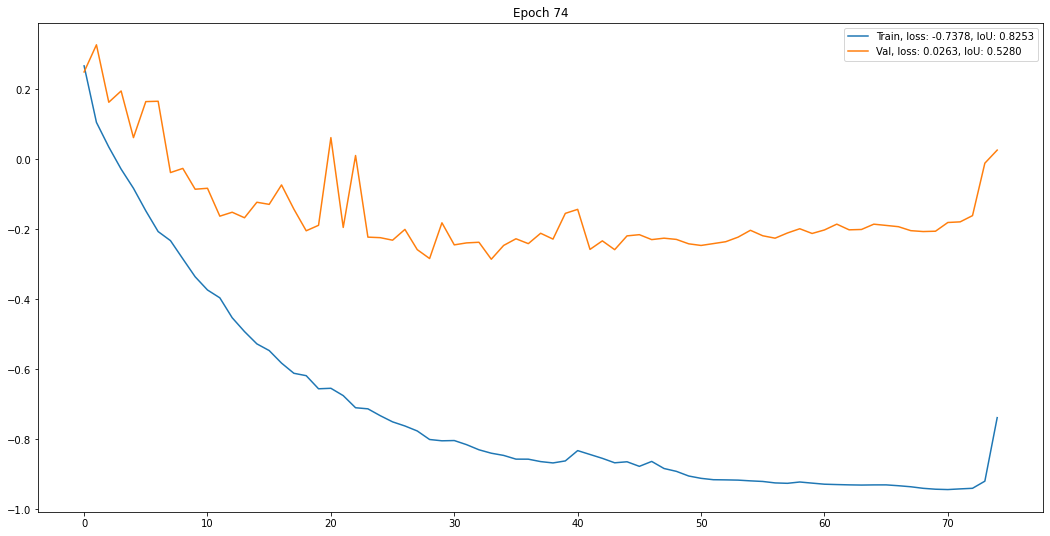

 Epoch: 75 of 100, Iter.: 44 of 44, Loss: -0.749192, Val. Loss: 0.004239
 Epoch: 75 of 100, Iter.: 44 of 44, IoU: 0.833603, Val. IoU: 0.563983


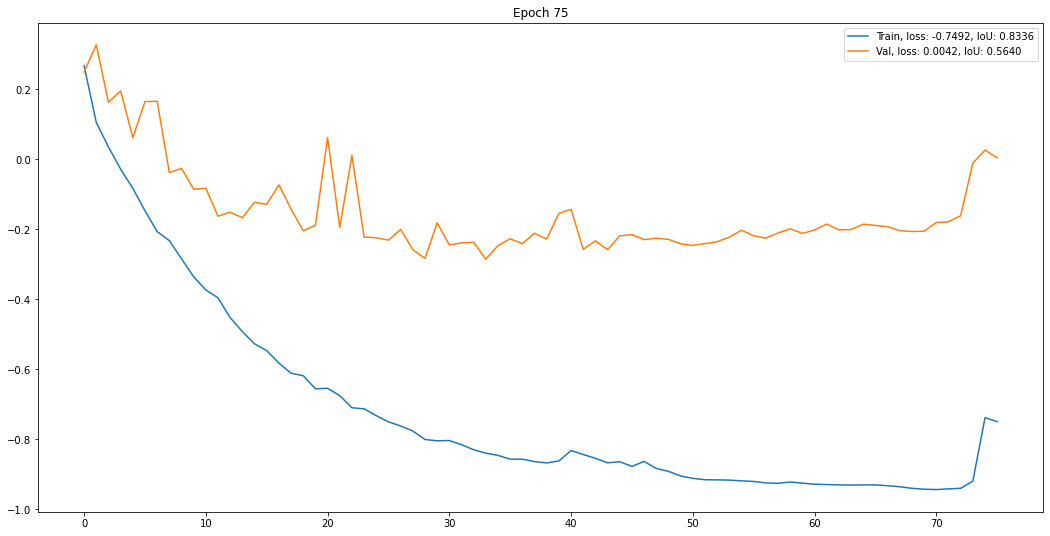

 Epoch: 76 of 100, Iter.: 44 of 44, Loss: -0.836141, Val. Loss: -0.136298
 Epoch: 76 of 100, Iter.: 44 of 44, IoU: 0.877229, Val. IoU: 0.592573


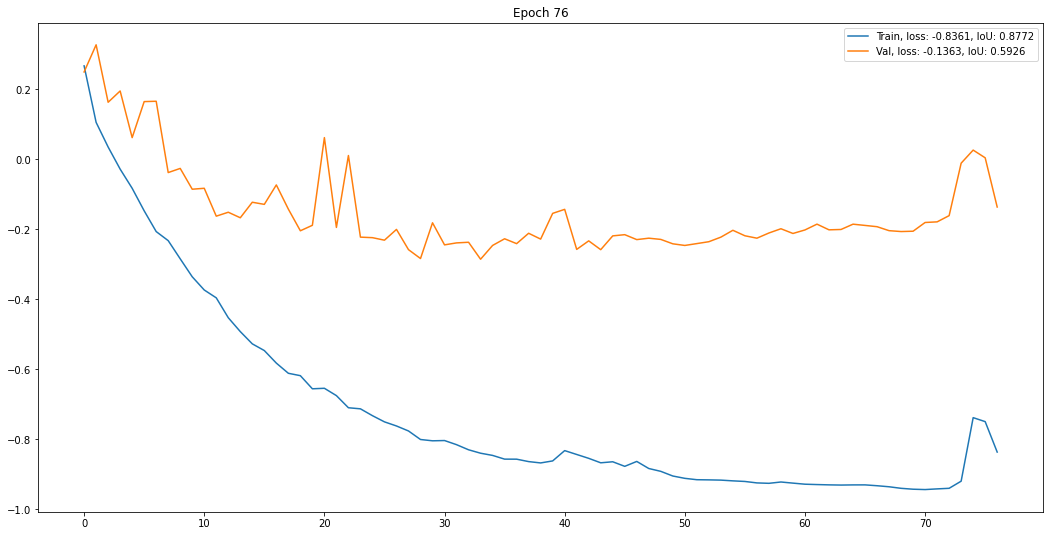

 Epoch: 77 of 100, Iter.: 44 of 44, Loss: -0.847951, Val. Loss: -0.161199
 Epoch: 77 of 100, Iter.: 44 of 44, IoU: 0.887113, Val. IoU: 0.612708


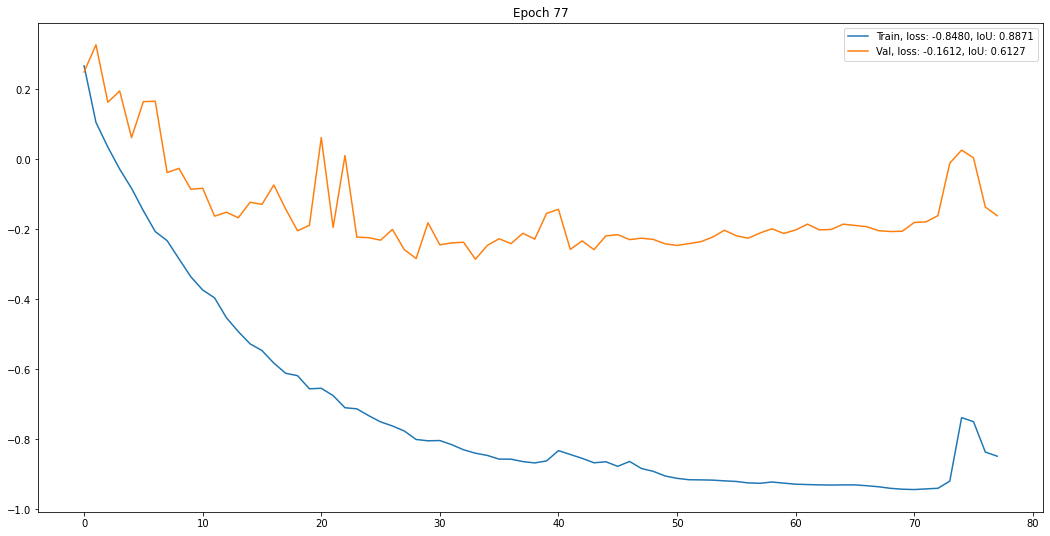

 Epoch: 78 of 100, Iter.: 44 of 44, Loss: -0.888905, Val. Loss: -0.188748
 Epoch: 78 of 100, Iter.: 44 of 44, IoU: 0.916962, Val. IoU: 0.626019


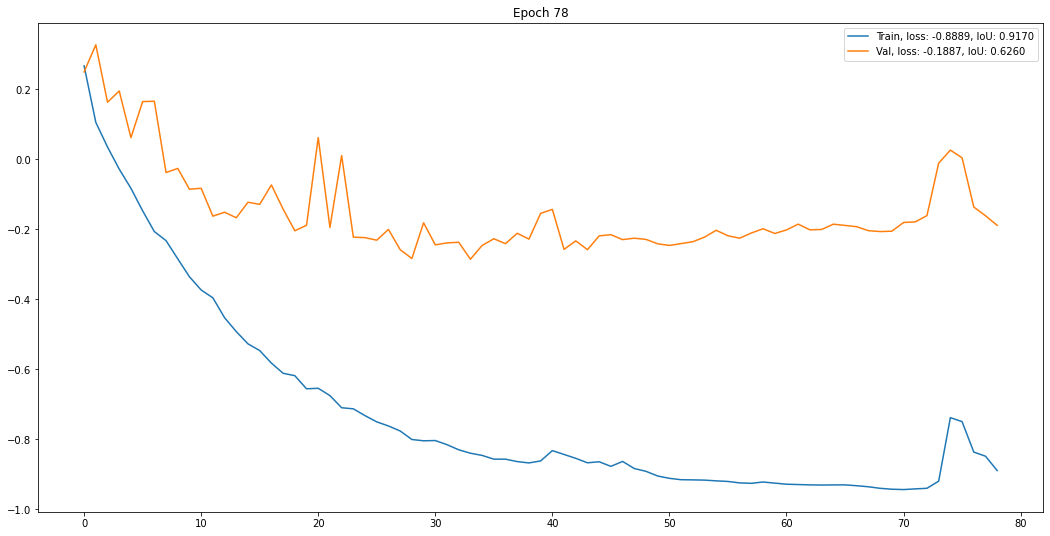

 Epoch: 79 of 100, Iter.: 44 of 44, Loss: -0.898691, Val. Loss: -0.016802
 Epoch: 79 of 100, Iter.: 44 of 44, IoU: 0.922197, Val. IoU: 0.566939


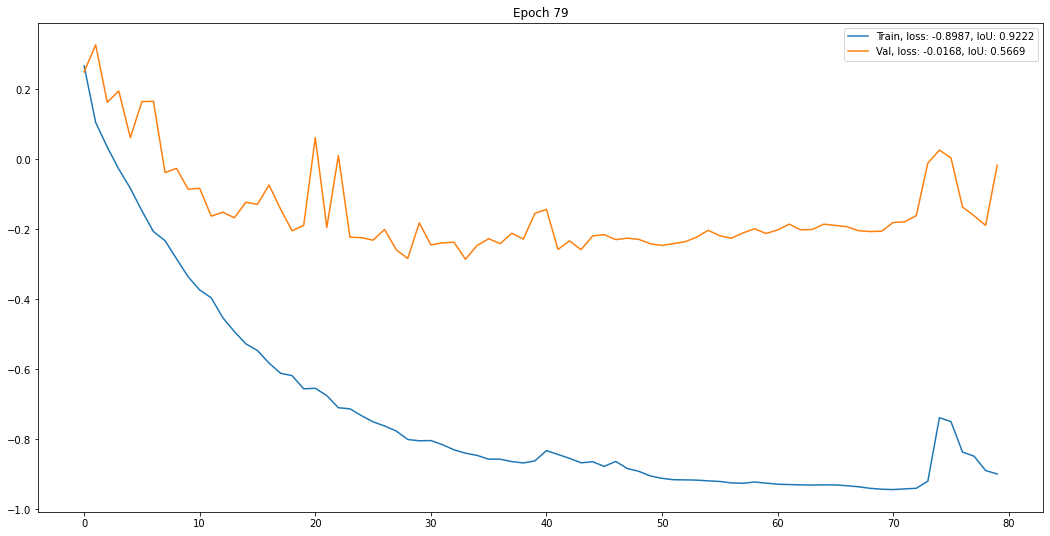

 Epoch: 80 of 100, Iter.: 44 of 44, Loss: -0.889162, Val. Loss: -0.118750
 Epoch: 80 of 100, Iter.: 44 of 44, IoU: 0.916966, Val. IoU: 0.603448


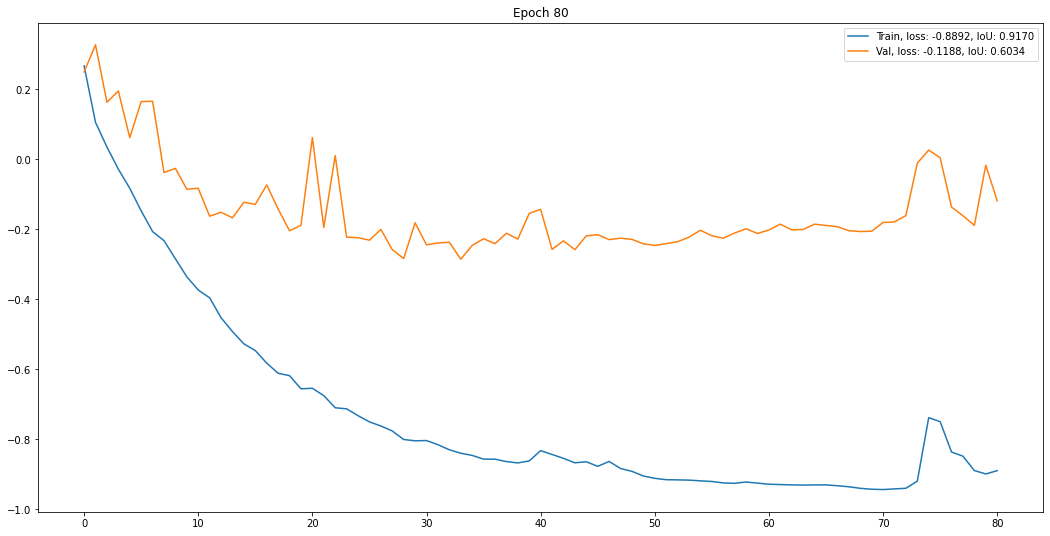

 Epoch: 81 of 100, Iter.: 44 of 44, Loss: -0.916061, Val. Loss: -0.126367
 Epoch: 81 of 100, Iter.: 44 of 44, IoU: 0.932914, Val. IoU: 0.614742


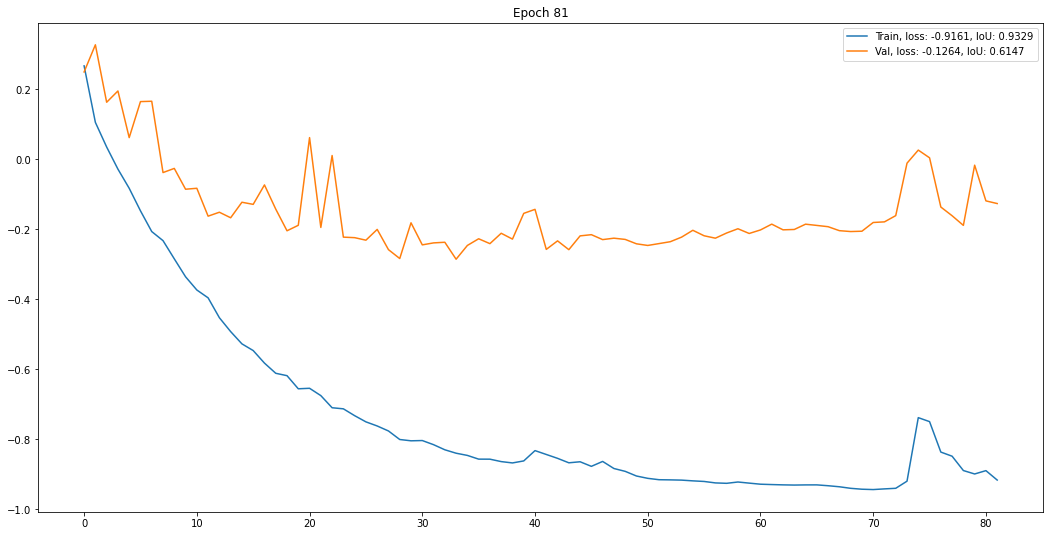

 Epoch: 82 of 100, Iter.: 44 of 44, Loss: -0.929672, Val. Loss: -0.159109
 Epoch: 82 of 100, Iter.: 44 of 44, IoU: 0.942294, Val. IoU: 0.625293


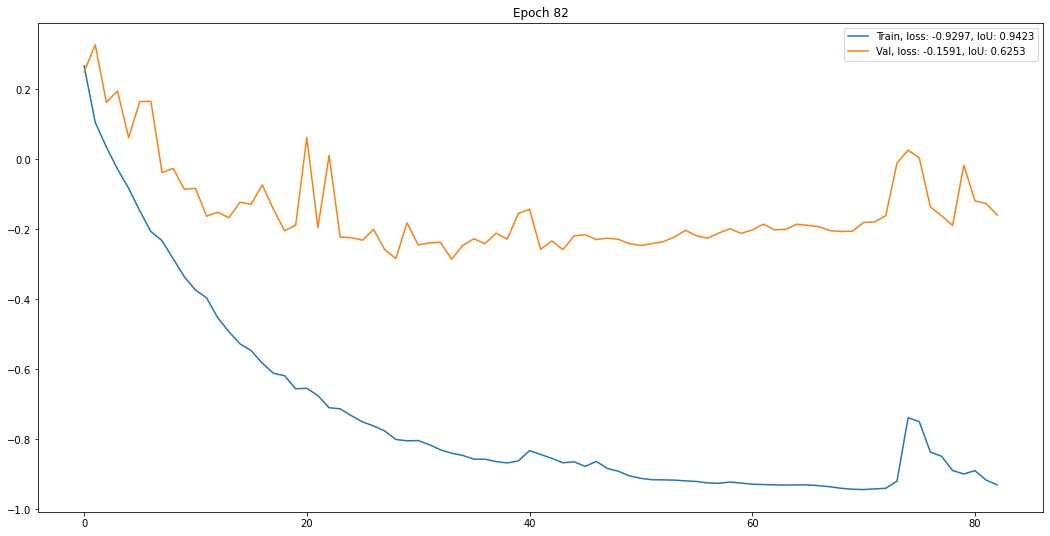

 Epoch: 83 of 100, Iter.: 44 of 44, Loss: -0.938911, Val. Loss: -0.190720
 Epoch: 83 of 100, Iter.: 44 of 44, IoU: 0.950628, Val. IoU: 0.634354


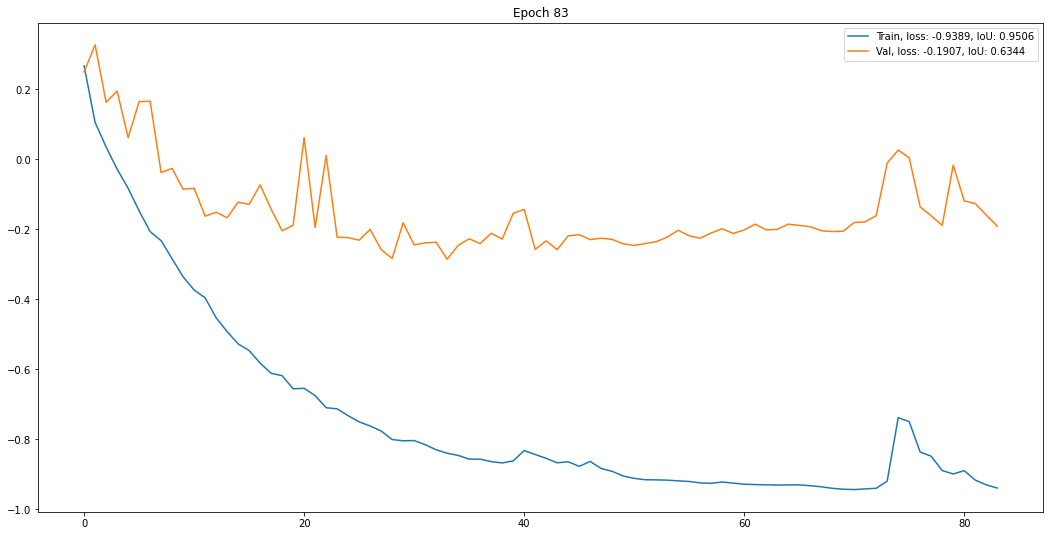

 Epoch: 84 of 100, Iter.: 44 of 44, Loss: -0.945142, Val. Loss: -0.177669
 Epoch: 84 of 100, Iter.: 44 of 44, IoU: 0.956056, Val. IoU: 0.634693


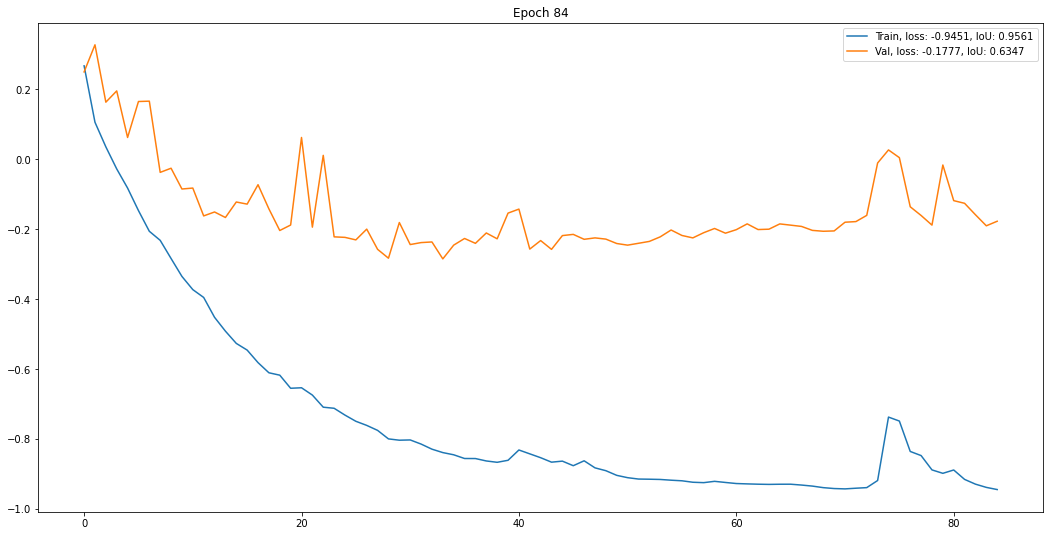

 Epoch: 85 of 100, Iter.: 44 of 44, Loss: -0.948656, Val. Loss: -0.156074
 Epoch: 85 of 100, Iter.: 44 of 44, IoU: 0.959414, Val. IoU: 0.630939


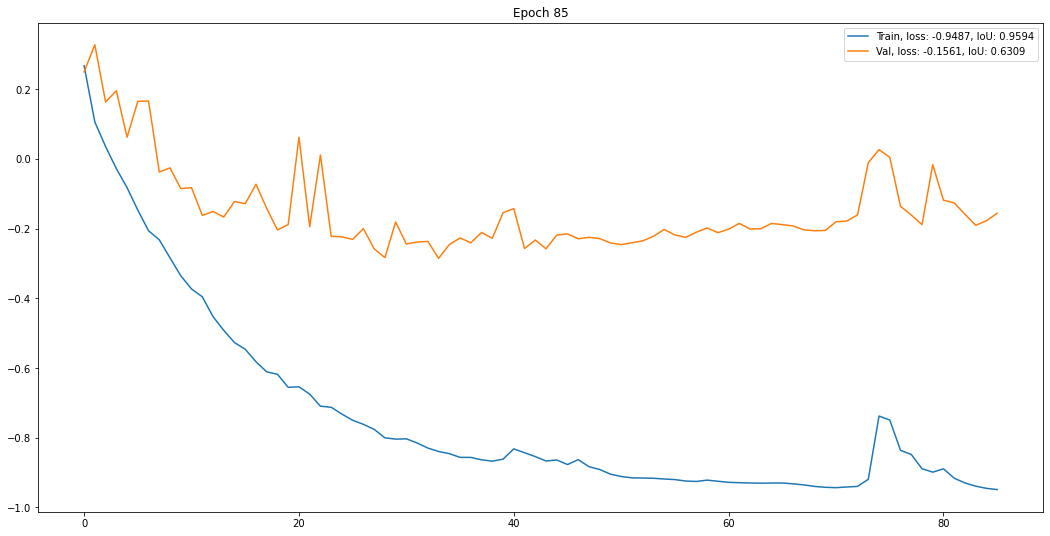

 Epoch: 86 of 100, Iter.: 44 of 44, Loss: -0.951473, Val. Loss: -0.152535
 Epoch: 86 of 100, Iter.: 44 of 44, IoU: 0.961831, Val. IoU: 0.630325


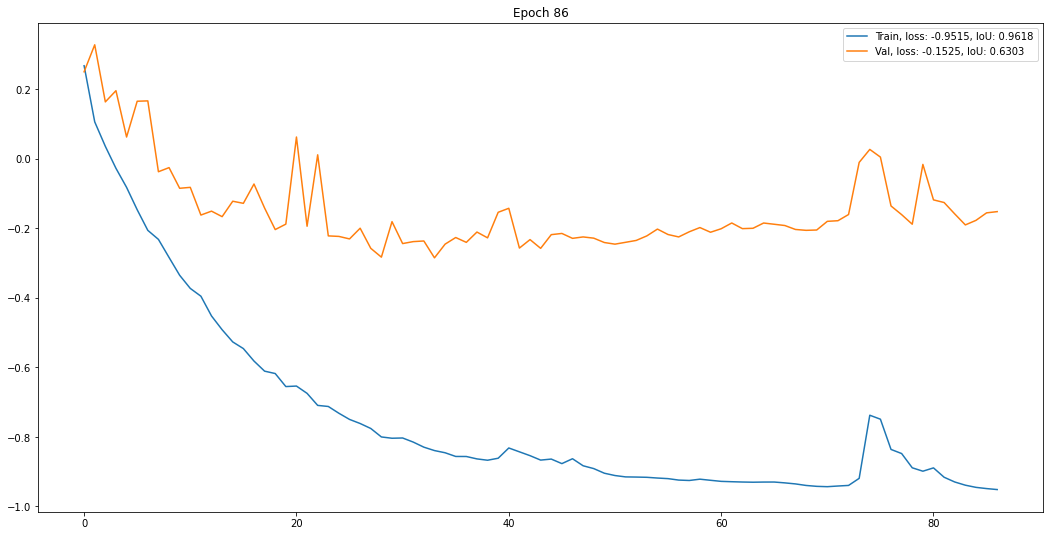

 Epoch: 87 of 100, Iter.: 44 of 44, Loss: -0.953389, Val. Loss: -0.145794
 Epoch: 87 of 100, Iter.: 44 of 44, IoU: 0.963307, Val. IoU: 0.632551


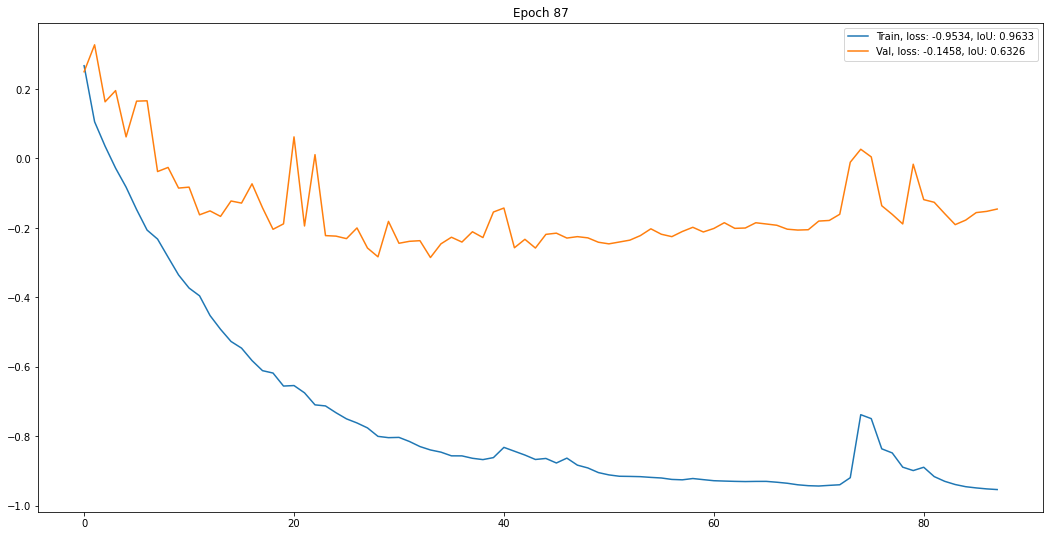

 Epoch: 88 of 100, Iter.: 44 of 44, Loss: -0.953577, Val. Loss: -0.131048
 Epoch: 88 of 100, Iter.: 44 of 44, IoU: 0.963354, Val. IoU: 0.628313


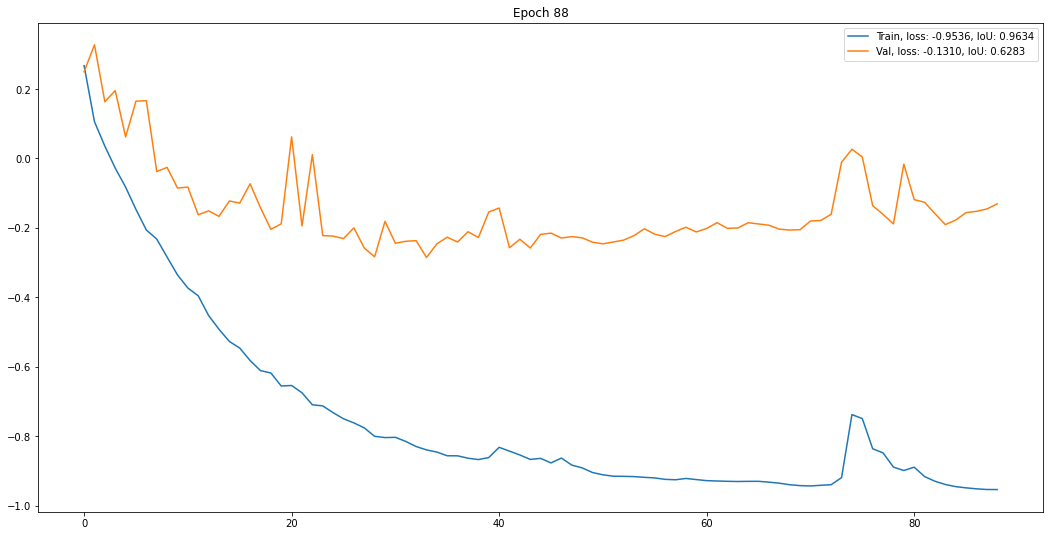

 Epoch: 89 of 100, Iter.: 44 of 44, Loss: -0.951726, Val. Loss: -0.120025
 Epoch: 89 of 100, Iter.: 44 of 44, IoU: 0.961753, Val. IoU: 0.626278


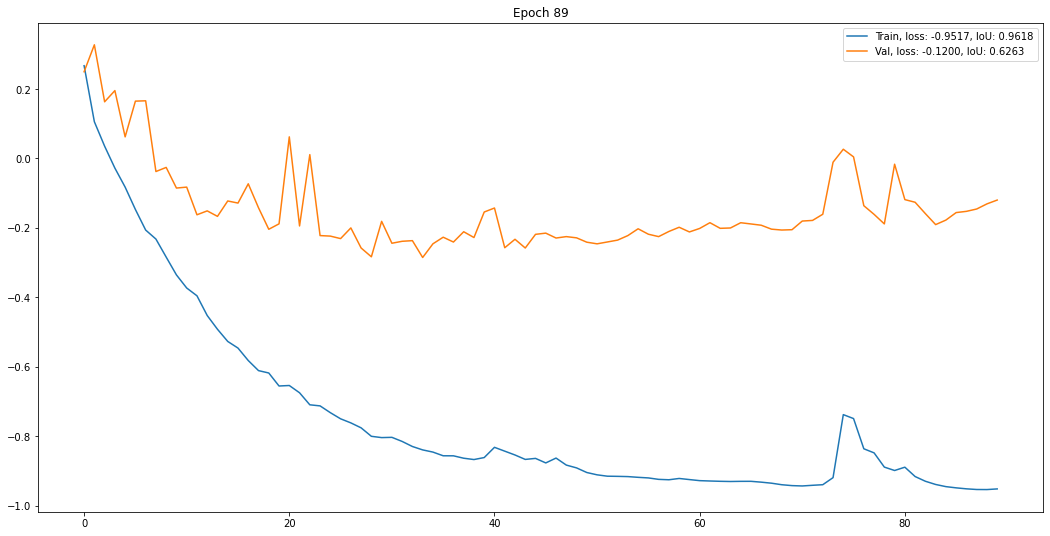

 Epoch: 90 of 100, Iter.: 44 of 44, Loss: -0.947189, Val. Loss: -0.134911
 Epoch: 90 of 100, Iter.: 44 of 44, IoU: 0.957368, Val. IoU: 0.627862


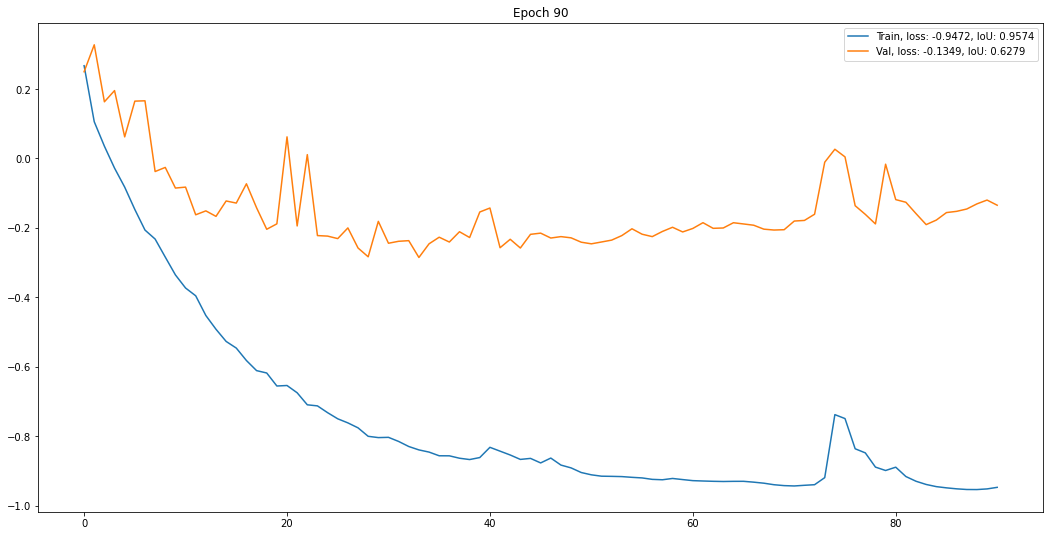

 Epoch: 91 of 100, Iter.: 44 of 44, Loss: -0.945158, Val. Loss: -0.157444
 Epoch: 91 of 100, Iter.: 44 of 44, IoU: 0.955571, Val. IoU: 0.627989


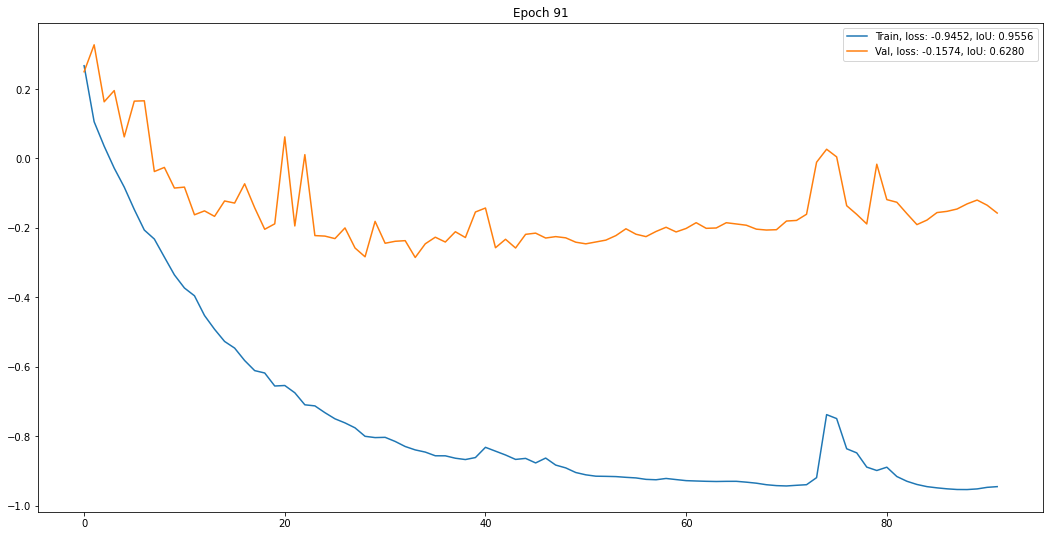

 Epoch: 92 of 100, Iter.: 44 of 44, Loss: -0.948353, Val. Loss: -0.146349
 Epoch: 92 of 100, Iter.: 44 of 44, IoU: 0.957829, Val. IoU: 0.629725


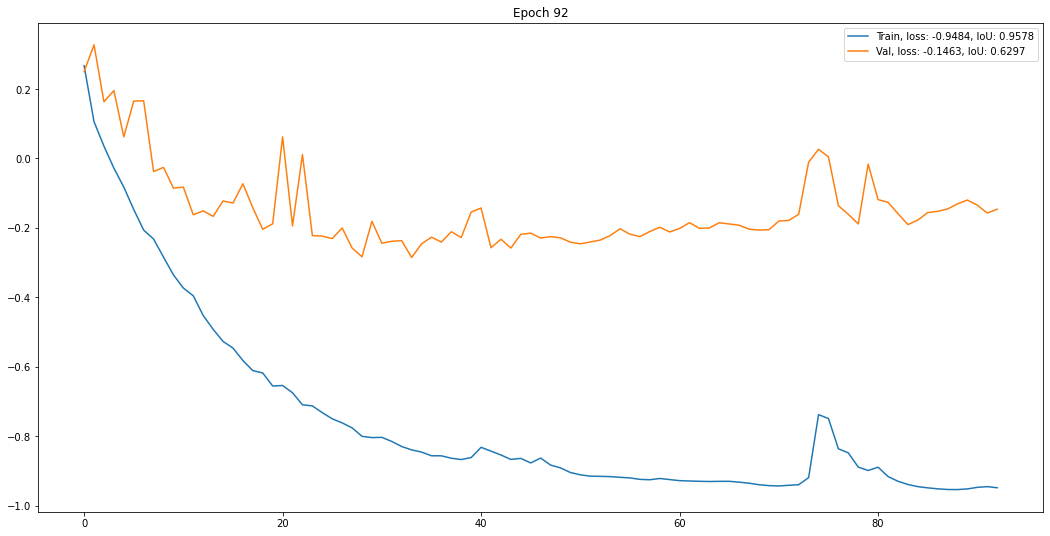

 Epoch: 93 of 100, Iter.: 44 of 44, Loss: -0.954030, Val. Loss: -0.145411
 Epoch: 93 of 100, Iter.: 44 of 44, IoU: 0.962639, Val. IoU: 0.636029


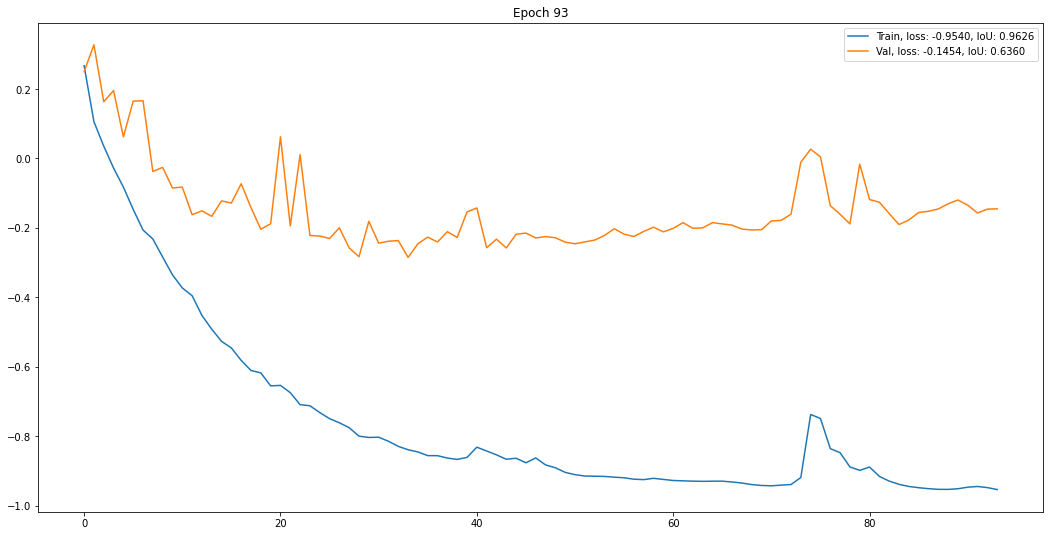

 Epoch: 94 of 100, Iter.: 44 of 44, Loss: -0.958957, Val. Loss: -0.134399
 Epoch: 94 of 100, Iter.: 44 of 44, IoU: 0.967169, Val. IoU: 0.631981


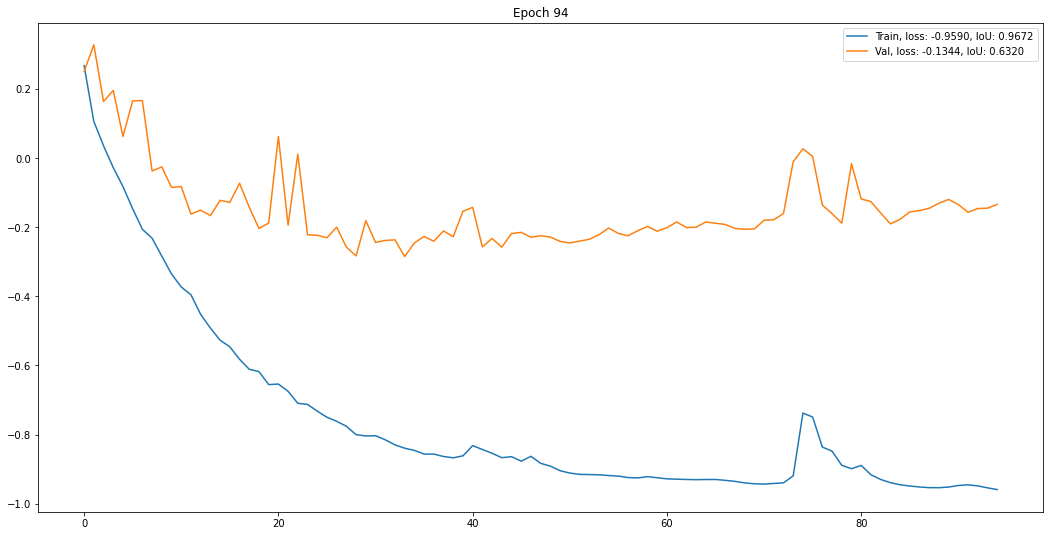

 Epoch: 95 of 100, Iter.: 44 of 44, Loss: -0.961058, Val. Loss: -0.139485
 Epoch: 95 of 100, Iter.: 44 of 44, IoU: 0.968866, Val. IoU: 0.638936


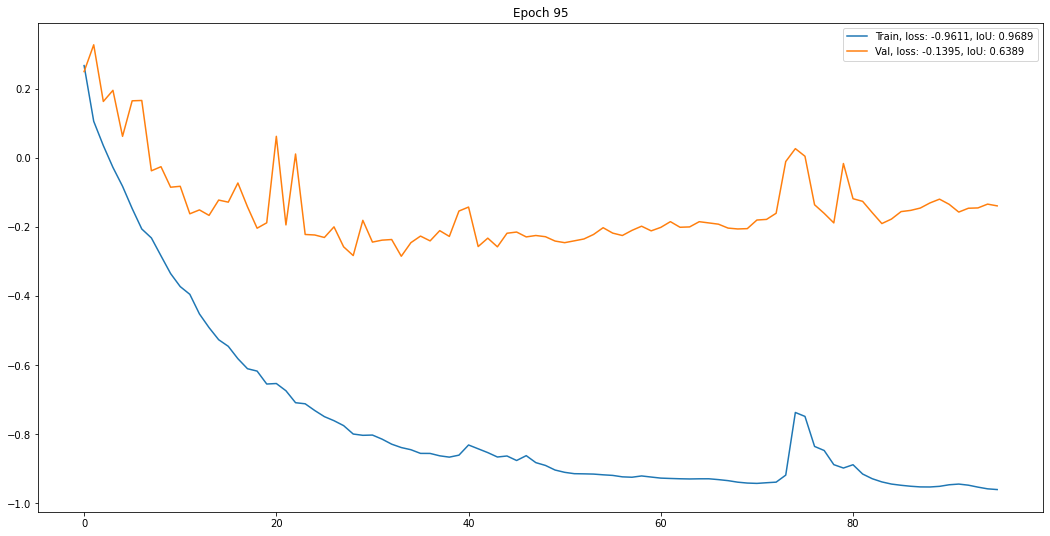

 Epoch: 96 of 100, Iter.: 44 of 44, Loss: -0.961920, Val. Loss: -0.125767
 Epoch: 96 of 100, Iter.: 44 of 44, IoU: 0.969796, Val. IoU: 0.636665


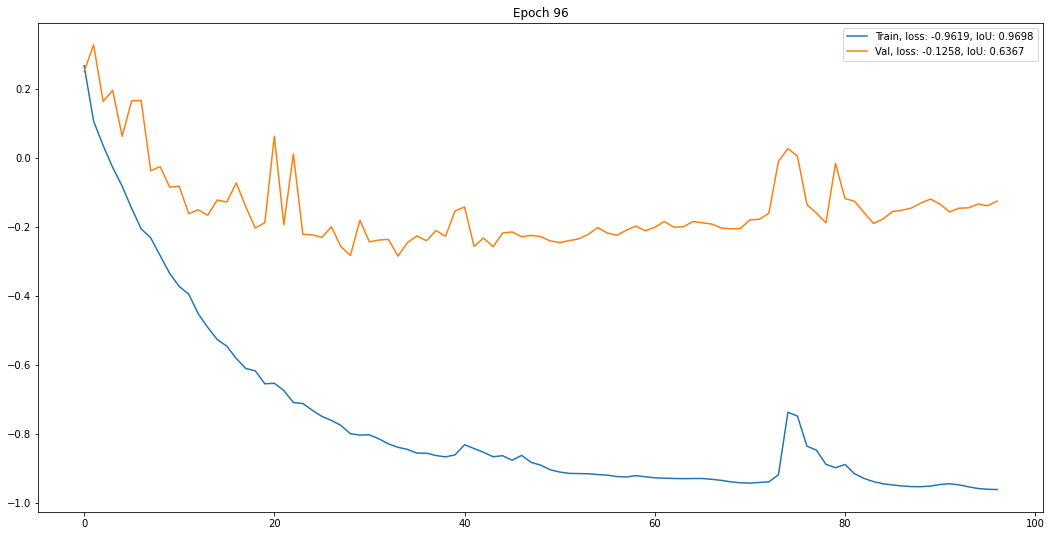

 Epoch: 97 of 100, Iter.: 44 of 44, Loss: -0.962641, Val. Loss: -0.104943
 Epoch: 97 of 100, Iter.: 44 of 44, IoU: 0.970375, Val. IoU: 0.624107


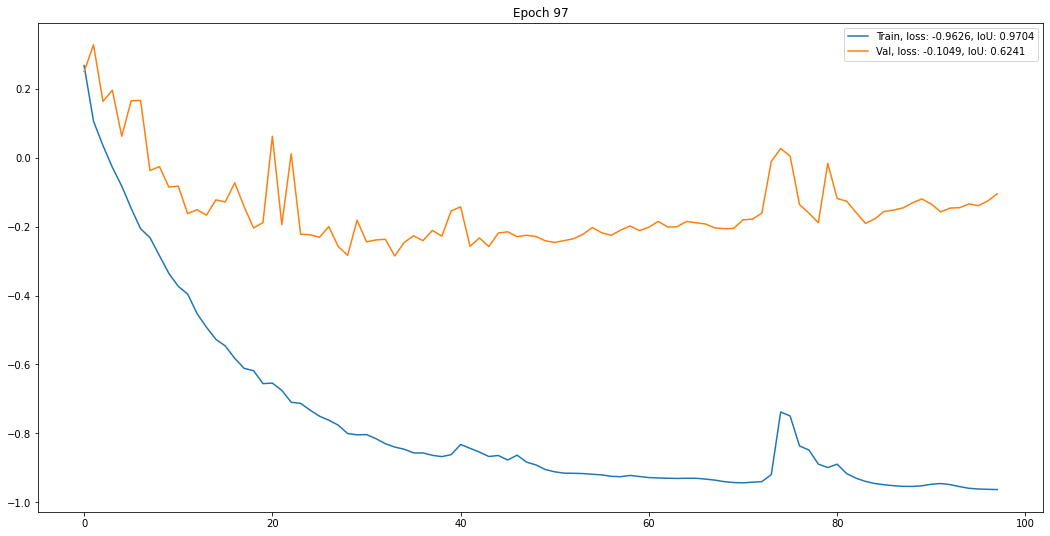

 Epoch: 98 of 100, Iter.: 44 of 44, Loss: -0.960817, Val. Loss: -0.101884
 Epoch: 98 of 100, Iter.: 44 of 44, IoU: 0.967941, Val. IoU: 0.618931


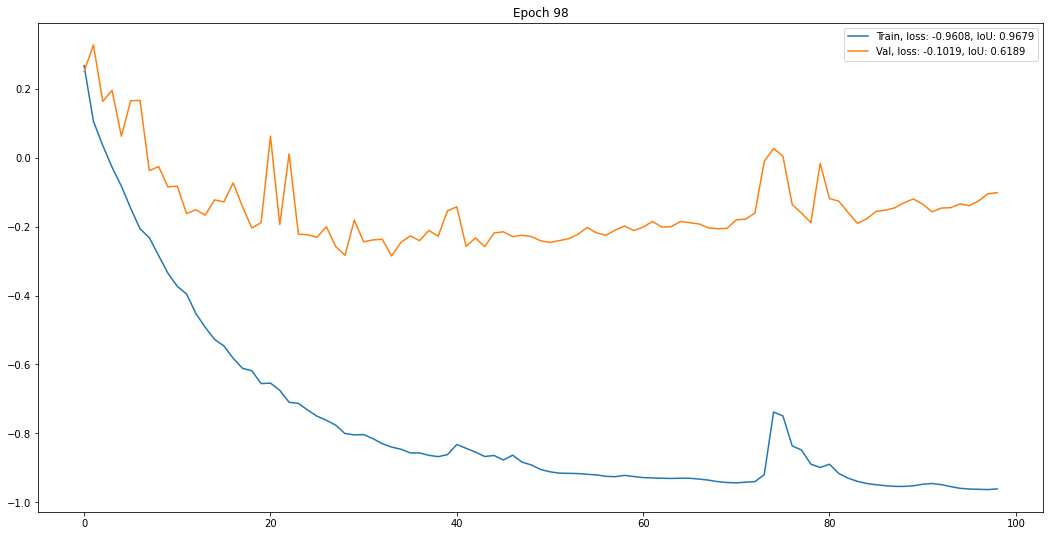

 Epoch: 99 of 100, Iter.: 44 of 44, Loss: -0.955912, Val. Loss: -0.100425
 Epoch: 99 of 100, Iter.: 44 of 44, IoU: 0.963005, Val. IoU: 0.617436


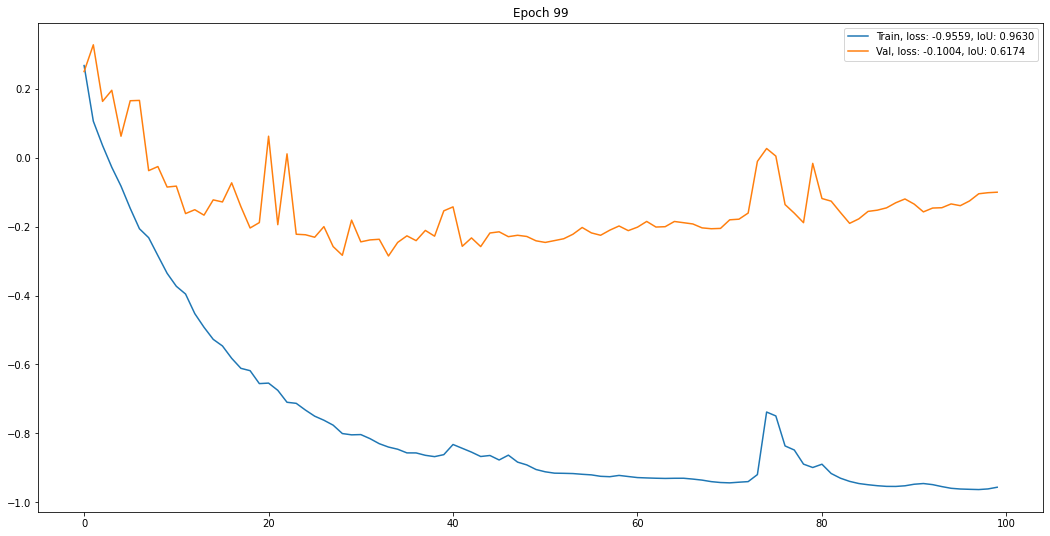

In [ ]:
train_losses = []
val_losses = []
best_iou = 0
best_loss = np.Inf
best_epoch = -1


for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    val_iou = 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)
    # compute overall epoch iou-s
    epoch_train_iou = running_iou/len(dataloader_train)
    epoch_val_iou = val_iou/len(dataloader_val)
    
    print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_val_loss))
    print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_iou, epoch_val_iou))
    
    
    # plot 
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}')
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()
    
    # save if best results
    best_iou = max(best_iou, epoch_val_iou)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
    if best_epoch == epoch:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'iou': best_iou,
            'epoch': epoch,
        }